# Libraries and Packages

In [1]:
# Uncomment for any libraries that are not installed

# %pip install transformers
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# %pip install numpy scipy scikit-learn pandas matplotlib
# %pip install imblearn
# %pip install nltk
# %pip install tqdm
# %pip install groq
# %pip install seaborn
# %pip install emoji

In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup, pipeline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import time
import datetime
from tqdm import tqdm
import os
import re
import emoji
from collections import Counter

# Dataset upload and CUDA switching

In [3]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Load the dataset
data_file = "train-balanced-sarcasm.csv"  # File must be in the same directory as this script
train_data = pd.read_csv(data_file)
train_data = train_data[['label','comment']]
train_data.head()

Using device: cuda


,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."
3,0,"This meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.


# Pre processing

In [4]:
# Funzione per pulire il testo
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = re.sub(r'http\S+', '', text)  # Rimuove URL
    text = re.sub(r'@\w+', '', text)  # Rimuove menzioni
    text = re.sub(r'#\w+', '', text)  # Rimuove hashtag
    text = re.sub(r'\d+', '', text)  # Rimuove numeri
    text = re.sub(r'[^\w\s]', '', text)  # Rimuove punteggiatura
    return text.lower().strip()

# Funzione per verificare se il testo è valido
def is_valid_text(text):
    # Rimuove emoji
    text = emoji.replace_emoji(text, '')
    # Rimuove spazi extra
    text = re.sub(r'\s+', ' ', text).strip()
    # Verifica se il testo ha almeno 3 parole e più di 10 caratteri
    words = text.split()
    
    # Verifica se ci sono parole ripetute più di 5 volte
    word_counts = Counter(words)
    if any(count > 5 for count in word_counts.values()):
        return False
    
    return len(words) >= 3 and len(text) > 10 and not text.isnumeric()
    



In [5]:
# Pulizia del dataset
print("Pulizia del dataset in corso...")
train_data['cleaned_comment'] = train_data['comment'].apply(clean_text)
train_data['is_valid'] = train_data['cleaned_comment'].apply(is_valid_text)
train_data = train_data[train_data['is_valid']]
train_data = train_data.drop('is_valid', axis=1)
train_data['comment'] = train_data['comment'].astype(str)
print("Pulizia del dataset completata...")

Pulizia del dataset in corso...
Pulizia del dataset completata...


### RoBERTa

**General description**

We have used a RoBERTa (A Robustly Optimized BERT Pretraining Approach) model, specifically the "*roberta-base*" variant, fine-tuned for sequence classification.
Key characteristics of this model include:

- **Architecture**: The RoBERTa model is based on the BERT architecture but with modifications in its pre-training approach. It consists of 12 transformer layers, 12 attention heads, and 768 hidden dimensions.

- **Pre-training**: This model was pre-trained on a significantly larger corpus compared to BERT, using dynamic masking and without the next sentence prediction task. The pre-training objective was masked language modeling, and RoBERTa was trained with larger batch sizes and learning rates, making it more robust in understanding language patterns.

- **Fine-tuning**: We've fine-tuned this pre-trained model for our specific task of sarcasm detection. A classification layer was added on top of the RoBERTa base model, and the model was trained on our sarcasm dataset.

- **Tokenizer**: It uses the RoBERTa tokenizer, which employs Byte-Pair Encoding (BPE) for tokenization.

- **Sequence Classification**: The model is configured for sequence classification, where it processes a sequence of tokens (e.g., a Reddit comment) and outputs a classification (sarcastic or not sarcastic).

- **Cased**: Unlike BERT's uncased variant, RoBERTa models are cased, meaning they differentiate between uppercase and lowercase letters. This can be beneficial for tasks where case sensitivity matters.

- **Size**: The "base" in "roberta-base" indicates that this is the smaller version of RoBERTa (as opposed to "roberta-large"), with about 125 million parameters.

This model is well-suited for our task because its robust pre-training allows it to capture complex language patterns that are crucial for detecting sarcasm. The fine-tuning process adapts this general language understanding to our specific task of sarcasm detection.

**Tokenization process**

The tokenization process in this project was performed using the RoBERTa tokenizer, specifically the one associated with the 'roberta-base' model. Here's a brief description of how it works:

*Tokenizer Initialization*:
The tokenizer is initialized using the `RobertaTokenizer.from_pretrained('roberta-base')` method. This loads the pre-trained tokenizer that matches the RoBERTa model we're using.
RoBERTa uses Byte-Pair Encoding (BPE) tokenization, which efficiently handles out-of-vocabulary words by breaking them into subwords. For example, "tokenization" might be split into "token" and "ization".

*Special Tokens*:
The tokenizer adds special tokens:

- **[CLS]**: RoBERTa does not use a [CLS] token. Instead, it relies on the first token of the sequence for classification tasks.
- **[SEP]**: Used at the end of each sequence or between sequences for pair tasks.

*Encoding*:
The tokenization process encodes each comment using the `encode_plus` method, which tokenizes the text, converts tokens to their respective IDs, adds special tokens, and generates attention masks (1 for real tokens, 0 for padding).

*Padding and Truncation*:
Sequences are padded to a maximum length (MAX_LEN = 128 in this case) with a padding token (usually [PAD]).
If a sequence is longer than MAX_LEN, it is truncated.

*Tensors Creation*:
The tokenized and encoded data is converted into PyTorch tensors for input to the model.

This process was applied to both the training and testing datasets, ensuring that the text input is in a format that the RoBERTa model can process. The use of Byte-Pair Encoding and special tokens allows the model to handle a wide variety of inputs, including words not encountered during pre-training.


In [6]:
# Campionamento
sample = 200000
train_data = train_data.head(sample)

print("Dataset pulito e filtrato. Dimensioni del nuovo DataFrame:", train_data.shape)
print("\nPrime 5 righe del DataFrame pulito:")
print(train_data.head())


comments = train_data.dropna().comment.values
labels = train_data.dropna().label.values

Dataset pulito e filtrato. Dimensioni del nuovo DataFrame: (200000, 3)

Prime 5 righe del DataFrame pulito:
   label                                            comment  \
1      0  You do know west teams play against west teams...   
2      0  They were underdogs earlier today, but since G...   
3      0  This meme isn't funny none of the "new york ni...   
4      0                    I could use one of those tools.   
5      0  I don't pay attention to her, but as long as s...   

                                     cleaned_comment  
1  you do know west teams play against west teams...  
2  they were underdogs earlier today but since gr...  
3  this meme isnt funny none of the new york nigg...  
4                     i could use one of those tools  
5  i dont pay attention to her but as long as she...  


In [11]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Initialize RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base')

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Tokenize and encode the dataset
MAX_LEN = 128
BATCH_SIZE = 32  # Adjust batch size as needed for your hardware

# Assuming `comments` is your list of comments and `labels` is your list of labels
input_ids = []
attention_masks = []

# Use tqdm for a progress bar during tokenization
for comment in tqdm(comments, desc="Tokenizing"):
    encoded_dict = tokenizer.encode_plus(
        comment,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert lists to tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

C:\Users\andre\anaconda3\envs\myenv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Tokenizing: 100%|██████████| 200000/200000 [00:32<00:00, 6156.69it/s]


In [12]:
# Create DataLoader
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32

train_dataloader = DataLoader(
    train_dataset,
    sampler=torch.utils.data.RandomSampler(train_dataset),
    batch_size=batch_size
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=torch.utils.data.SequentialSampler(val_dataset),
    batch_size=batch_size
)

In [13]:
# Load pre-trained BERT model
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

#### Optimization

In [14]:
# Set up optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

C:\Users\andre\anaconda3\envs\myenv\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#### Training

In [15]:
# Training loop RoBERTa

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round(elapsed))))

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

total_t0 = time.time()

for epoch_i in range(0, epochs):
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(f'  Batch {step}  of  {len(train_dataloader)}.    Elapsed: {elapsed}.')

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epoch took: {training_time}")
        
    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
            
        loss = outputs.loss
        logits = outputs.logits
        
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print(f"  Accuracy: {avg_val_accuracy:.2f}")

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    
    print(f"  Validation Loss: {avg_val_loss:.2f}")
    print(f"  Validation took: {validation_time}")

print("")
print("Training complete!")
print(f"Total training took {format_time(time.time()-total_t0)}")

======== Epoch 1 / 5 ========
Training...
  Batch 40  of  5625.    Elapsed: 0:00:14.
  Batch 80  of  5625.    Elapsed: 0:00:28.
  Batch 120  of  5625.    Elapsed: 0:00:41.
  Batch 160  of  5625.    Elapsed: 0:00:55.
  Batch 200  of  5625.    Elapsed: 0:01:08.
  Batch 240  of  5625.    Elapsed: 0:01:22.
  Batch 280  of  5625.    Elapsed: 0:01:37.
  Batch 320  of  5625.    Elapsed: 0:01:51.
  Batch 360  of  5625.    Elapsed: 0:02:05.
  Batch 400  of  5625.    Elapsed: 0:02:19.
  Batch 440  of  5625.    Elapsed: 0:02:33.
  Batch 480  of  5625.    Elapsed: 0:02:47.
  Batch 520  of  5625.    Elapsed: 0:03:01.
  Batch 560  of  5625.    Elapsed: 0:03:15.
  Batch 600  of  5625.    Elapsed: 0:03:29.
  Batch 640  of  5625.    Elapsed: 0:03:43.
  Batch 680  of  5625.    Elapsed: 0:03:57.
  Batch 720  of  5625.    Elapsed: 0:04:10.
  Batch 760  of  5625.    Elapsed: 0:04:24.
  Batch 800  of  5625.    Elapsed: 0:04:38.
  Batch 840  of  5625.    Elapsed: 0:04:52.
  Batch 880  of  5625.    Elapsed: 0

  Batch 1560  of  5625.    Elapsed: 0:09:09.
  Batch 1600  of  5625.    Elapsed: 0:09:23.
  Batch 1640  of  5625.    Elapsed: 0:09:37.
  Batch 1680  of  5625.    Elapsed: 0:09:52.
  Batch 1720  of  5625.    Elapsed: 0:10:06.
  Batch 1760  of  5625.    Elapsed: 0:10:20.
  Batch 1800  of  5625.    Elapsed: 0:10:34.
  Batch 1840  of  5625.    Elapsed: 0:10:49.
  Batch 1880  of  5625.    Elapsed: 0:11:03.
  Batch 1920  of  5625.    Elapsed: 0:11:17.
  Batch 1960  of  5625.    Elapsed: 0:11:32.
  Batch 2000  of  5625.    Elapsed: 0:11:46.
  Batch 2040  of  5625.    Elapsed: 0:12:00.
  Batch 2080  of  5625.    Elapsed: 0:12:14.
  Batch 2120  of  5625.    Elapsed: 0:12:29.
  Batch 2160  of  5625.    Elapsed: 0:12:43.
  Batch 2200  of  5625.    Elapsed: 0:12:57.
  Batch 2240  of  5625.    Elapsed: 0:13:12.
  Batch 2280  of  5625.    Elapsed: 0:13:26.
  Batch 2320  of  5625.    Elapsed: 0:13:40.
  Batch 2360  of  5625.    Elapsed: 0:13:55.
  Batch 2400  of  5625.    Elapsed: 0:14:09.
  Batch 24

  Batch 3120  of  5625.    Elapsed: 0:18:13.
  Batch 3160  of  5625.    Elapsed: 0:18:27.
  Batch 3200  of  5625.    Elapsed: 0:18:42.
  Batch 3240  of  5625.    Elapsed: 0:18:56.
  Batch 3280  of  5625.    Elapsed: 0:19:10.
  Batch 3320  of  5625.    Elapsed: 0:19:24.
  Batch 3360  of  5625.    Elapsed: 0:19:39.
  Batch 3400  of  5625.    Elapsed: 0:19:53.
  Batch 3440  of  5625.    Elapsed: 0:20:07.
  Batch 3480  of  5625.    Elapsed: 0:20:21.
  Batch 3520  of  5625.    Elapsed: 0:20:36.
  Batch 3560  of  5625.    Elapsed: 0:20:50.
  Batch 3600  of  5625.    Elapsed: 0:21:04.
  Batch 3640  of  5625.    Elapsed: 0:21:18.
  Batch 3680  of  5625.    Elapsed: 0:21:33.
  Batch 3720  of  5625.    Elapsed: 0:21:47.
  Batch 3760  of  5625.    Elapsed: 0:22:01.
  Batch 3800  of  5625.    Elapsed: 0:22:15.
  Batch 3840  of  5625.    Elapsed: 0:22:30.
  Batch 3880  of  5625.    Elapsed: 0:22:44.
  Batch 3920  of  5625.    Elapsed: 0:22:58.
  Batch 3960  of  5625.    Elapsed: 0:23:12.
  Batch 40

  Batch 4680  of  5625.    Elapsed: 0:27:14.
  Batch 4720  of  5625.    Elapsed: 0:27:28.
  Batch 4760  of  5625.    Elapsed: 0:27:42.
  Batch 4800  of  5625.    Elapsed: 0:27:56.
  Batch 4840  of  5625.    Elapsed: 0:28:10.
  Batch 4880  of  5625.    Elapsed: 0:28:24.
  Batch 4920  of  5625.    Elapsed: 0:28:38.
  Batch 4960  of  5625.    Elapsed: 0:28:51.
  Batch 5000  of  5625.    Elapsed: 0:29:05.
  Batch 5040  of  5625.    Elapsed: 0:29:19.
  Batch 5080  of  5625.    Elapsed: 0:29:33.
  Batch 5120  of  5625.    Elapsed: 0:29:47.
  Batch 5160  of  5625.    Elapsed: 0:30:01.
  Batch 5200  of  5625.    Elapsed: 0:30:15.
  Batch 5240  of  5625.    Elapsed: 0:30:29.
  Batch 5280  of  5625.    Elapsed: 0:30:43.
  Batch 5320  of  5625.    Elapsed: 0:30:57.
  Batch 5360  of  5625.    Elapsed: 0:31:10.
  Batch 5400  of  5625.    Elapsed: 0:31:24.
  Batch 5440  of  5625.    Elapsed: 0:31:38.
  Batch 5480  of  5625.    Elapsed: 0:31:52.
  Batch 5520  of  5625.    Elapsed: 0:32:06.
  Batch 55

In [16]:
# Specifica la directory di output
output_dir = os.path.expanduser(r"C:\Users\andre\OneDrive\Desktop\Modelli NLP/roberta_sarcasm_model2/")

# Crea la directory se non esiste già
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"Saving model to {output_dir}")

# Salva il modello (incluso il controllo per modelli paralleli)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

# Salva il tokenizer
tokenizer.save_pretrained(output_dir)

print("Model and tokenizer saved!")



Saving model to C:\Users\andre\OneDrive\Desktop\Modelli NLP/roberta_sarcasm_model/
Model and tokenizer saved!


#### Deployment

In [8]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the saved model and tokenizer
model_path = r"C:\Users\andre\OneDrive\Desktop\Modelli NLP\roberta_sarcasm_model2"
model = RobertaForSequenceClassification.from_pretrained(model_path)
tokenizer = RobertaTokenizer.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def predict_sarcasm(text):
    # Tokenize and encode the text
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )
    
    input_ids = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)
    
    # Perform inference
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
    
    # Get prediction
    prediction = torch.argmax(logits, dim=1).item()
    probability = torch.nn.functional.softmax(logits, dim=1)[0][prediction].item()
    
    return "Sarcastic" if prediction == 1 else "Not sarcastic", probability

In [9]:
# Test the model with some example texts
example_texts = [
    "I absolutely love waiting in long lines at the DMV.",
    "The weather is beautiful today.",
    "Wow, getting a root canal is so much fun!",
    "I'm excited about the new movie coming out.",
    "This is the best day ever! My car broke down and I lost my wallet.",
    "Oh, great, another update that 'improves' the app by making it crash even more. Thanks, developers!",
    "Sure, because spending an entire day in line at the DMV is exactly how I wanted to spend my Saturday.",
    "Wow, this 50-page instruction manual for a simple coffee maker is exactly what I needed. So intuitive!",
    "Of course, I love when my internet cuts out right in the middle of a critical work meeting. Who doesn't?",
    "Yeah, because nothing says 'professionalism' like sending an email in Comic Sans.",
    "I think this new feature will be really useful for organizing my projects.",
    "Thanks for the suggestion! I'll definitely check out that book.",
    "I completely agree with you, the new season of the show is much better than the last one.",
    "That recipe turned out great! Thanks for sharing it with us.",
    "I had a great experience with their customer service, they were really helpful and responsive."
]

print("Predicting sarcasm for example texts:")
for text in example_texts:
    prediction, probability = predict_sarcasm(text)
    print(f"Text: {text}")
    print(f"Prediction: {prediction} (Probability: {probability:.2f})")
    print()

Predicting sarcasm for example texts:
Text: I absolutely love waiting in long lines at the DMV.
Prediction: Sarcastic (Probability: 0.98)

Text: The weather is beautiful today.
Prediction: Not sarcastic (Probability: 0.92)

Text: Wow, getting a root canal is so much fun!
Prediction: Sarcastic (Probability: 0.99)

Text: I'm excited about the new movie coming out.
Prediction: Not sarcastic (Probability: 0.96)

Text: This is the best day ever! My car broke down and I lost my wallet.
Prediction: Not sarcastic (Probability: 0.93)

Text: Oh, great, another update that 'improves' the app by making it crash even more. Thanks, developers!
Prediction: Sarcastic (Probability: 0.97)

Text: Sure, because spending an entire day in line at the DMV is exactly how I wanted to spend my Saturday.
Prediction: Sarcastic (Probability: 0.99)

Text: Wow, this 50-page instruction manual for a simple coffee maker is exactly what I needed. So intuitive!
Prediction: Sarcastic (Probability: 0.99)

Text: Of course,

#### Evaluation

In [10]:
# Load and evaluate on test dataset
test_data = pd.read_csv("test_sarcasm.csv")

def prepare_data(data):
    input_ids = []
    attention_masks = []
    
    for comment in data['comment']:
        encoded_dict = tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=128,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    return input_ids, attention_masks

input_ids, attention_masks = prepare_data(test_data)
labels = torch.tensor(test_data['label'].values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\andre\anaconda3\envs\myenv\Lib\site-packages\transformers\tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [11]:
# Create the DataLoader
test_dataset = TensorDataset(input_ids, attention_masks, labels)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Evaluation
predictions = []
true_labels = []

In [12]:
for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_attention_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_attention_mask)
    
    logits = outputs[0]
    batch_predictions = torch.argmax(logits, dim=1).flatten()
    
    predictions.extend(batch_predictions.cpu().numpy())
    true_labels.extend(b_labels.cpu().numpy())
    

In [22]:
# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

print("Model Performance on Test Set:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Model Performance on Test Set:
Accuracy: 0.79
Precision: 0.81
Recall: 0.77
F1 Score: 0.79


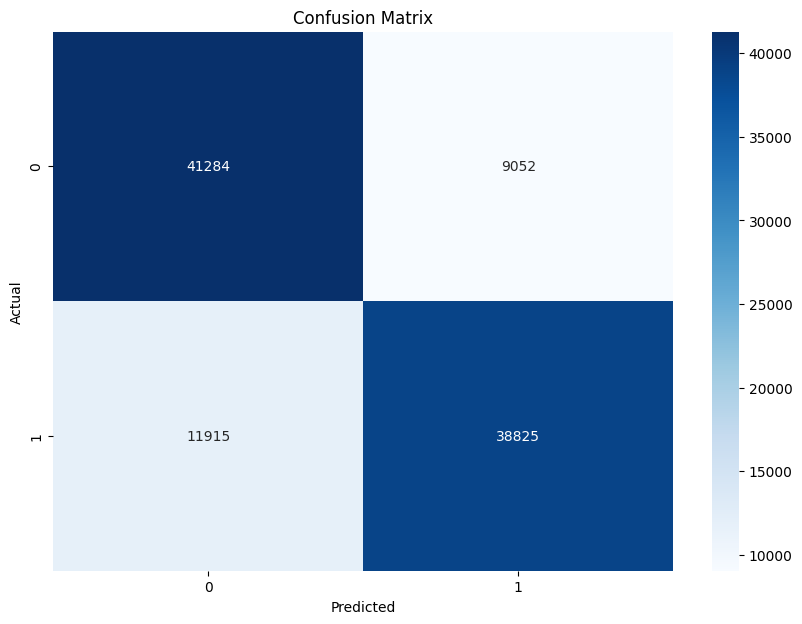

In [23]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

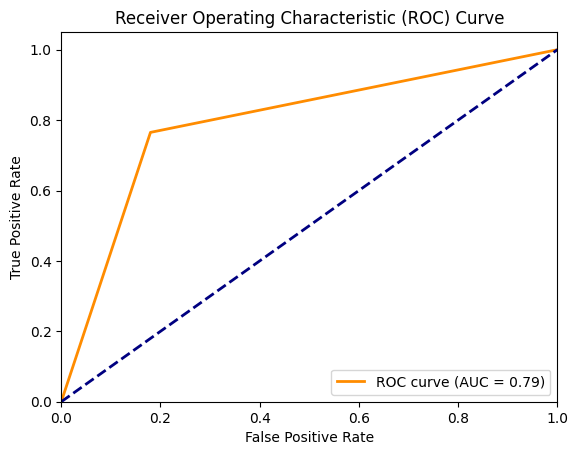

In [13]:
# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### DistilBERT

**General description**

We have used a DistilBERT (Distilled version of BERT) model, specifically the "*distilbert-base-uncased*" variant, fine-tuned for sequence classification.
Key characteristics of this model include:

- **Architecture**: DistilBERT is a smaller, faster, and lighter version of BERT. It retains 6 transformer layers, 12 attention heads, and 768 hidden dimensions. This is achieved through a process called knowledge distillation, where a smaller model (DistilBERT) is trained to replicate the performance of a larger model (BERT).

- **Pre-training**: This model was pre-trained on a large corpus of uncased English text (meaning it treats "The" and "the" as the same token). DistilBERT was trained using the same masked language modeling task as BERT but without the next sentence prediction task. The distillation process compresses the knowledge from BERT into a smaller model, maintaining about 97% of BERT's performance while being 60% faster and 40% smaller.

- **Fine-tuning**: We've fine-tuned this pre-trained model for our specific task of sarcasm detection. This involves adding a classification layer on top of the DistilBERT base and training on our sarcasm dataset.

- **Tokenizer**: It uses the DistilBERT tokenizer, which employs WordPiece tokenization, identical to that used by BERT.

- **Sequence Classification**: The model is set up for sequence classification, where it processes a sequence of tokens (e.g., a Reddit comment) and outputs a classification (sarcastic or not sarcastic).

- **Uncased**: As mentioned, this version is uncased, meaning it doesn't differentiate between uppercase and lowercase letters. This can be beneficial for tasks where case doesn't carry significant meaning, potentially reducing the vocabulary size and model complexity.

- **Size**: The "base" in "distilbert-base-uncased" indicates that this is the smaller version of DistilBERT, with about 66 million parameters, making it significantly more efficient in terms of memory and computational cost compared to BERT.

This model is well-suited for our task because it balances performance and efficiency, capturing complex language patterns essential for detecting sarcasm while being faster and lighter than the full BERT model. The fine-tuning process adapts this general language understanding to our specific task of sarcasm detection.

**Tokenization process**

The tokenization process in this project was performed using the DistilBERT tokenizer, specifically the one associated with the 'distilbert-base-uncased' model. Here's a brief description of how it works:

*Tokenizer Initialization*:
The tokenizer is initialized using the `DistilBertTokenizer.from_pretrained('distilbert-base-uncased')` method. This loads the pre-trained tokenizer that matches the DistilBERT model we're using.
The 'uncased' version of the tokenizer converts all text to lowercase before tokenization. DistilBERT uses WordPiece tokenization, which breaks words into subwords. This helps handle out-of-vocabulary words and reduces the overall vocabulary size. For example, "tokenization" might be broken into "token" and "##ization".

*Special Tokens*:
The tokenizer adds special tokens:

- **[CLS]**: DistilBERT uses a [CLS] token at the beginning of each sequence, which is used for classification tasks.
- **[SEP]**: Used at the end of each sequence (or between sequences for pair tasks).

*Encoding*:
The tokenization process encodes each comment using the `encode_plus` method, which tokenizes the text, converts tokens to their respective IDs, adds special tokens, and generates attention masks (1 for real tokens, 0 for padding).

*Padding and Truncation*:
Sequences are padded to a maximum length (MAX_LEN = 128 in this case) with a padding token (usually [PAD]).
If a sequence is longer than MAX_LEN, it is truncated.

*Tensors Creation*:
The tokenized and encoded data is converted into PyTorch tensors for input to the model.

This process was applied to both the training and testing datasets, ensuring that the text input is in a format that the DistilBERT model can process. The use of subword tokenization and special tokens allows the model to handle a wide variety of inputs, including words it hasn't seen during pre-training.


#### Pre processing

In [7]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW

# Inizializza il tokenizer di DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

# Carica il modello pre-addestrato DistilBERT
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,  # Numero di etichette (esempio: 2 per classificazione binaria)
    output_attentions=False,
    output_hidden_states=False,
)

# Sposta il modello sul dispositivo appropriato (GPU o CPU)
model.to(device)


C:\Users\andre\anaconda3\envs\myenv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [8]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Initialize DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Tokenize and encode the dataset
MAX_LEN = 128

# Assuming `comments` is your list of comments and `labels` is your list of labels
input_ids = []
attention_masks = []

# Use tqdm for a progress bar during tokenization
for comment in tqdm(comments, desc="Tokenizing"):
    encoded_dict = tokenizer.encode_plus(
        comment,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert lists to tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Move tensors to the appropriate device
input_ids = input_ids.to(device)
attention_masks = attention_masks.to(device)
labels = labels.to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Tokenizing: 100%|██████████| 200000/200000 [00:53<00:00, 3762.85it/s]


In [9]:
# Create DataLoader
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32

train_dataloader = DataLoader(
    train_dataset,
    sampler=torch.utils.data.RandomSampler(train_dataset),
    batch_size=batch_size
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=torch.utils.data.SequentialSampler(val_dataset),
    batch_size=batch_size
)

In [10]:
# Load pre-trained DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

#### Optimization

In [11]:
# Set up optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

C:\Users\andre\anaconda3\envs\myenv\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#### Training

In [12]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round(elapsed))))

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

total_t0 = time.time()

for epoch_i in range(0, epochs):
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    # Aggiunta di tqdm per la barra di progresso durante il training
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(f'  Batch {step}  of  {len(train_dataloader)}.    Elapsed: {elapsed}.')

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids,  
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print(f"\n  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epoch took: {training_time}")
        
    print("\nRunning Validation...")

    t0 = time.time()
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0

    # Aggiunta di tqdm per la barra di progresso durante la validazione
    for batch in tqdm(validation_dataloader, desc="Validation"):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            outputs = model(b_input_ids, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
            
        loss = outputs.loss
        logits = outputs.logits
        
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print(f"  Accuracy: {avg_val_accuracy:.2f}")

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    
    print(f"  Validation Loss: {avg_val_loss:.2f}")
    print(f"  Validation took: {validation_time}")

print("")
print("Training complete!")
print(f"Total training took {format_time(time.time()-total_t0)}")

======== Epoch 1 / 5 ========
Training...


Training:   1%|          | 41/5625 [00:08<16:36,  5.60it/s] 

  Batch 40  of  5625.    Elapsed: 0:00:08.


Training:   1%|▏         | 81/5625 [00:15<15:59,  5.78it/s]

  Batch 80  of  5625.    Elapsed: 0:00:15.


Training:   2%|▏         | 121/5625 [00:22<15:46,  5.81it/s]

  Batch 120  of  5625.    Elapsed: 0:00:22.


Training:   3%|▎         | 161/5625 [00:29<16:12,  5.62it/s]

  Batch 160  of  5625.    Elapsed: 0:00:29.


Training:   4%|▎         | 201/5625 [00:36<16:15,  5.56it/s]

  Batch 200  of  5625.    Elapsed: 0:00:37.


Training:   4%|▍         | 241/5625 [00:43<15:50,  5.66it/s]

  Batch 240  of  5625.    Elapsed: 0:00:44.


Training:   5%|▍         | 281/5625 [00:51<16:30,  5.40it/s]

  Batch 280  of  5625.    Elapsed: 0:00:51.


Training:   6%|▌         | 321/5625 [00:58<15:44,  5.62it/s]

  Batch 320  of  5625.    Elapsed: 0:00:58.


Training:   6%|▋         | 361/5625 [01:05<15:53,  5.52it/s]

  Batch 360  of  5625.    Elapsed: 0:01:05.


Training:   7%|▋         | 401/5625 [01:12<15:32,  5.60it/s]

  Batch 400  of  5625.    Elapsed: 0:01:13.


Training:   8%|▊         | 441/5625 [01:19<15:32,  5.56it/s]

  Batch 440  of  5625.    Elapsed: 0:01:20.


Training:   9%|▊         | 481/5625 [01:27<15:38,  5.48it/s]

  Batch 480  of  5625.    Elapsed: 0:01:27.


Training:   9%|▉         | 521/5625 [01:34<15:21,  5.54it/s]

  Batch 520  of  5625.    Elapsed: 0:01:34.


Training:  10%|▉         | 561/5625 [01:41<15:25,  5.47it/s]

  Batch 560  of  5625.    Elapsed: 0:01:42.


Training:  11%|█         | 601/5625 [01:49<16:06,  5.20it/s]

  Batch 600  of  5625.    Elapsed: 0:01:49.


Training:  11%|█▏        | 641/5625 [01:57<15:09,  5.48it/s]

  Batch 640  of  5625.    Elapsed: 0:01:57.


Training:  12%|█▏        | 681/5625 [02:04<15:03,  5.47it/s]

  Batch 680  of  5625.    Elapsed: 0:02:04.


Training:  13%|█▎        | 721/5625 [02:11<14:56,  5.47it/s]

  Batch 720  of  5625.    Elapsed: 0:02:12.


Training:  14%|█▎        | 761/5625 [02:19<14:36,  5.55it/s]

  Batch 760  of  5625.    Elapsed: 0:02:19.


Training:  14%|█▍        | 801/5625 [02:26<15:04,  5.33it/s]

  Batch 800  of  5625.    Elapsed: 0:02:26.


Training:  15%|█▍        | 841/5625 [02:33<14:33,  5.48it/s]

  Batch 840  of  5625.    Elapsed: 0:02:34.


Training:  16%|█▌        | 881/5625 [02:41<14:40,  5.39it/s]

  Batch 880  of  5625.    Elapsed: 0:02:41.


Training:  16%|█▋        | 921/5625 [02:48<14:05,  5.56it/s]

  Batch 920  of  5625.    Elapsed: 0:02:48.


Training:  17%|█▋        | 961/5625 [02:55<14:03,  5.53it/s]

  Batch 960  of  5625.    Elapsed: 0:02:55.


Training:  18%|█▊        | 1001/5625 [03:03<13:50,  5.57it/s]

  Batch 1000  of  5625.    Elapsed: 0:03:03.


Training:  19%|█▊        | 1041/5625 [03:10<13:48,  5.54it/s]

  Batch 1040  of  5625.    Elapsed: 0:03:10.


Training:  19%|█▉        | 1081/5625 [03:17<13:50,  5.47it/s]

  Batch 1080  of  5625.    Elapsed: 0:03:17.


Training:  20%|█▉        | 1121/5625 [03:24<13:27,  5.58it/s]

  Batch 1120  of  5625.    Elapsed: 0:03:25.


Training:  21%|██        | 1161/5625 [03:32<13:54,  5.35it/s]

  Batch 1160  of  5625.    Elapsed: 0:03:32.


Training:  21%|██▏       | 1201/5625 [03:39<13:27,  5.48it/s]

  Batch 1200  of  5625.    Elapsed: 0:03:39.


Training:  22%|██▏       | 1241/5625 [03:47<15:09,  4.82it/s]

  Batch 1240  of  5625.    Elapsed: 0:03:47.


Training:  23%|██▎       | 1281/5625 [03:54<13:15,  5.46it/s]

  Batch 1280  of  5625.    Elapsed: 0:03:55.


Training:  23%|██▎       | 1321/5625 [04:02<13:34,  5.28it/s]

  Batch 1320  of  5625.    Elapsed: 0:04:02.


Training:  24%|██▍       | 1361/5625 [04:09<13:01,  5.46it/s]

  Batch 1360  of  5625.    Elapsed: 0:04:09.


Training:  25%|██▍       | 1401/5625 [04:16<13:54,  5.06it/s]

  Batch 1400  of  5625.    Elapsed: 0:04:17.


Training:  26%|██▌       | 1441/5625 [04:24<12:39,  5.51it/s]

  Batch 1440  of  5625.    Elapsed: 0:04:24.


Training:  26%|██▋       | 1481/5625 [04:31<12:33,  5.50it/s]

  Batch 1480  of  5625.    Elapsed: 0:04:32.


Training:  27%|██▋       | 1521/5625 [04:39<12:31,  5.46it/s]

  Batch 1520  of  5625.    Elapsed: 0:04:39.


Training:  28%|██▊       | 1561/5625 [04:46<12:25,  5.45it/s]

  Batch 1560  of  5625.    Elapsed: 0:04:46.


Training:  28%|██▊       | 1601/5625 [04:53<12:08,  5.52it/s]

  Batch 1600  of  5625.    Elapsed: 0:04:54.


Training:  29%|██▉       | 1641/5625 [05:01<12:11,  5.45it/s]

  Batch 1640  of  5625.    Elapsed: 0:05:01.


Training:  30%|██▉       | 1681/5625 [05:08<12:08,  5.42it/s]

  Batch 1680  of  5625.    Elapsed: 0:05:08.


Training:  31%|███       | 1721/5625 [05:15<11:55,  5.46it/s]

  Batch 1720  of  5625.    Elapsed: 0:05:16.


Training:  31%|███▏      | 1761/5625 [05:23<11:55,  5.40it/s]

  Batch 1760  of  5625.    Elapsed: 0:05:23.


Training:  32%|███▏      | 1801/5625 [05:30<11:30,  5.54it/s]

  Batch 1800  of  5625.    Elapsed: 0:05:30.


Training:  33%|███▎      | 1841/5625 [05:37<11:54,  5.30it/s]

  Batch 1840  of  5625.    Elapsed: 0:05:38.


Training:  33%|███▎      | 1881/5625 [05:45<12:38,  4.93it/s]

  Batch 1880  of  5625.    Elapsed: 0:05:45.


Training:  34%|███▍      | 1921/5625 [05:53<11:34,  5.33it/s]

  Batch 1920  of  5625.    Elapsed: 0:05:53.


Training:  35%|███▍      | 1961/5625 [06:00<11:19,  5.40it/s]

  Batch 1960  of  5625.    Elapsed: 0:06:00.


Training:  36%|███▌      | 2000/5625 [06:07<11:05,  5.45it/s]

  Batch 2000  of  5625.    Elapsed: 0:06:08.


Training:  36%|███▋      | 2041/5625 [06:15<11:03,  5.40it/s]

  Batch 2040  of  5625.    Elapsed: 0:06:15.


Training:  37%|███▋      | 2081/5625 [06:22<10:36,  5.57it/s]

  Batch 2080  of  5625.    Elapsed: 0:06:22.


Training:  38%|███▊      | 2121/5625 [06:30<10:48,  5.40it/s]

  Batch 2120  of  5625.    Elapsed: 0:06:30.


Training:  38%|███▊      | 2161/5625 [06:37<10:31,  5.49it/s]

  Batch 2160  of  5625.    Elapsed: 0:06:37.


Training:  39%|███▉      | 2201/5625 [06:44<10:36,  5.38it/s]

  Batch 2200  of  5625.    Elapsed: 0:06:45.


Training:  40%|███▉      | 2241/5625 [06:52<10:11,  5.53it/s]

  Batch 2240  of  5625.    Elapsed: 0:06:52.


Training:  41%|████      | 2281/5625 [06:59<10:31,  5.30it/s]

  Batch 2280  of  5625.    Elapsed: 0:06:59.


Training:  41%|████▏     | 2321/5625 [07:06<10:01,  5.49it/s]

  Batch 2320  of  5625.    Elapsed: 0:07:07.


Training:  42%|████▏     | 2361/5625 [07:14<10:25,  5.22it/s]

  Batch 2360  of  5625.    Elapsed: 0:07:14.


Training:  43%|████▎     | 2401/5625 [07:21<09:42,  5.53it/s]

  Batch 2400  of  5625.    Elapsed: 0:07:21.


Training:  43%|████▎     | 2441/5625 [07:28<09:44,  5.44it/s]

  Batch 2440  of  5625.    Elapsed: 0:07:29.


Training:  44%|████▍     | 2481/5625 [07:36<09:31,  5.50it/s]

  Batch 2480  of  5625.    Elapsed: 0:07:36.


Training:  45%|████▍     | 2521/5625 [07:43<09:37,  5.38it/s]

  Batch 2520  of  5625.    Elapsed: 0:07:43.


Training:  46%|████▌     | 2561/5625 [07:51<09:31,  5.36it/s]

  Batch 2560  of  5625.    Elapsed: 0:07:51.


Training:  46%|████▌     | 2601/5625 [07:58<09:15,  5.44it/s]

  Batch 2600  of  5625.    Elapsed: 0:07:59.


Training:  47%|████▋     | 2641/5625 [08:06<09:14,  5.38it/s]

  Batch 2640  of  5625.    Elapsed: 0:08:06.


Training:  48%|████▊     | 2681/5625 [08:13<08:55,  5.50it/s]

  Batch 2680  of  5625.    Elapsed: 0:08:13.


Training:  48%|████▊     | 2721/5625 [08:21<08:59,  5.38it/s]

  Batch 2720  of  5625.    Elapsed: 0:08:21.


Training:  49%|████▉     | 2761/5625 [08:28<08:46,  5.44it/s]

  Batch 2760  of  5625.    Elapsed: 0:08:28.


Training:  50%|████▉     | 2801/5625 [08:35<08:46,  5.37it/s]

  Batch 2800  of  5625.    Elapsed: 0:08:36.


Training:  51%|█████     | 2841/5625 [08:43<08:22,  5.54it/s]

  Batch 2840  of  5625.    Elapsed: 0:08:43.


Training:  51%|█████     | 2881/5625 [08:50<08:44,  5.23it/s]

  Batch 2880  of  5625.    Elapsed: 0:08:50.


Training:  52%|█████▏    | 2921/5625 [08:57<08:15,  5.46it/s]

  Batch 2920  of  5625.    Elapsed: 0:08:58.


Training:  53%|█████▎    | 2961/5625 [09:05<08:18,  5.34it/s]

  Batch 2960  of  5625.    Elapsed: 0:09:05.


Training:  53%|█████▎    | 3001/5625 [09:12<07:53,  5.54it/s]

  Batch 3000  of  5625.    Elapsed: 0:09:13.


Training:  54%|█████▍    | 3041/5625 [09:20<07:58,  5.40it/s]

  Batch 3040  of  5625.    Elapsed: 0:09:20.


Training:  55%|█████▍    | 3081/5625 [09:27<07:47,  5.44it/s]

  Batch 3080  of  5625.    Elapsed: 0:09:27.


Training:  55%|█████▌    | 3121/5625 [09:34<07:42,  5.42it/s]

  Batch 3120  of  5625.    Elapsed: 0:09:35.


Training:  56%|█████▌    | 3161/5625 [09:42<07:29,  5.48it/s]

  Batch 3160  of  5625.    Elapsed: 0:09:42.


Training:  57%|█████▋    | 3201/5625 [09:50<07:43,  5.23it/s]

  Batch 3200  of  5625.    Elapsed: 0:09:50.


Training:  58%|█████▊    | 3241/5625 [09:57<07:24,  5.36it/s]

  Batch 3240  of  5625.    Elapsed: 0:09:58.


Training:  58%|█████▊    | 3281/5625 [10:05<07:11,  5.43it/s]

  Batch 3280  of  5625.    Elapsed: 0:10:05.


Training:  59%|█████▉    | 3321/5625 [10:12<07:09,  5.36it/s]

  Batch 3320  of  5625.    Elapsed: 0:10:12.


Training:  60%|█████▉    | 3361/5625 [10:19<06:58,  5.41it/s]

  Batch 3360  of  5625.    Elapsed: 0:10:20.


Training:  60%|██████    | 3401/5625 [10:27<07:07,  5.20it/s]

  Batch 3400  of  5625.    Elapsed: 0:10:27.


Training:  61%|██████    | 3441/5625 [10:34<06:54,  5.27it/s]

  Batch 3440  of  5625.    Elapsed: 0:10:35.


Training:  62%|██████▏   | 3481/5625 [10:42<06:52,  5.20it/s]

  Batch 3480  of  5625.    Elapsed: 0:10:42.


Training:  63%|██████▎   | 3521/5625 [10:49<06:30,  5.39it/s]

  Batch 3520  of  5625.    Elapsed: 0:10:50.


Training:  63%|██████▎   | 3561/5625 [10:57<06:31,  5.27it/s]

  Batch 3560  of  5625.    Elapsed: 0:10:57.


Training:  64%|██████▍   | 3601/5625 [11:04<06:14,  5.40it/s]

  Batch 3600  of  5625.    Elapsed: 0:11:04.


Training:  65%|██████▍   | 3641/5625 [11:11<06:06,  5.42it/s]

  Batch 3640  of  5625.    Elapsed: 0:11:12.


Training:  65%|██████▌   | 3681/5625 [11:19<05:57,  5.44it/s]

  Batch 3680  of  5625.    Elapsed: 0:11:19.


Training:  66%|██████▌   | 3721/5625 [11:26<05:50,  5.43it/s]

  Batch 3720  of  5625.    Elapsed: 0:11:27.


Training:  67%|██████▋   | 3761/5625 [11:34<05:42,  5.44it/s]

  Batch 3760  of  5625.    Elapsed: 0:11:34.


Training:  68%|██████▊   | 3801/5625 [11:41<05:31,  5.50it/s]

  Batch 3800  of  5625.    Elapsed: 0:11:41.


Training:  68%|██████▊   | 3841/5625 [11:49<05:40,  5.23it/s]

  Batch 3840  of  5625.    Elapsed: 0:11:49.


Training:  69%|██████▉   | 3881/5625 [11:56<05:15,  5.52it/s]

  Batch 3880  of  5625.    Elapsed: 0:11:57.


Training:  70%|██████▉   | 3921/5625 [12:04<05:11,  5.47it/s]

  Batch 3920  of  5625.    Elapsed: 0:12:04.


Training:  70%|███████   | 3961/5625 [12:11<04:59,  5.55it/s]

  Batch 3960  of  5625.    Elapsed: 0:12:11.


Training:  71%|███████   | 4001/5625 [12:19<05:09,  5.25it/s]

  Batch 4000  of  5625.    Elapsed: 0:12:19.


Training:  72%|███████▏  | 4041/5625 [12:26<04:51,  5.43it/s]

  Batch 4040  of  5625.    Elapsed: 0:12:26.


Training:  73%|███████▎  | 4081/5625 [12:33<04:48,  5.35it/s]

  Batch 4080  of  5625.    Elapsed: 0:12:34.


Training:  73%|███████▎  | 4121/5625 [12:41<04:33,  5.51it/s]

  Batch 4120  of  5625.    Elapsed: 0:12:41.


Training:  74%|███████▍  | 4161/5625 [12:48<04:33,  5.36it/s]

  Batch 4160  of  5625.    Elapsed: 0:12:48.


Training:  75%|███████▍  | 4201/5625 [12:56<04:24,  5.39it/s]

  Batch 4200  of  5625.    Elapsed: 0:12:56.


Training:  75%|███████▌  | 4241/5625 [13:03<04:09,  5.54it/s]

  Batch 4240  of  5625.    Elapsed: 0:13:03.


Training:  76%|███████▌  | 4281/5625 [13:10<04:06,  5.46it/s]

  Batch 4280  of  5625.    Elapsed: 0:13:11.


Training:  77%|███████▋  | 4321/5625 [13:18<03:59,  5.43it/s]

  Batch 4320  of  5625.    Elapsed: 0:13:18.


Training:  78%|███████▊  | 4361/5625 [13:25<03:53,  5.41it/s]

  Batch 4360  of  5625.    Elapsed: 0:13:25.


Training:  78%|███████▊  | 4401/5625 [13:32<03:40,  5.54it/s]

  Batch 4400  of  5625.    Elapsed: 0:13:33.


Training:  79%|███████▉  | 4441/5625 [13:40<03:36,  5.47it/s]

  Batch 4440  of  5625.    Elapsed: 0:13:40.


Training:  80%|███████▉  | 4480/5625 [13:48<04:01,  4.74it/s]

  Batch 4480  of  5625.    Elapsed: 0:13:48.


Training:  80%|████████  | 4521/5625 [13:56<03:28,  5.28it/s]

  Batch 4520  of  5625.    Elapsed: 0:13:56.


Training:  81%|████████  | 4561/5625 [14:03<03:16,  5.42it/s]

  Batch 4560  of  5625.    Elapsed: 0:14:04.


Training:  82%|████████▏ | 4601/5625 [14:11<03:13,  5.30it/s]

  Batch 4600  of  5625.    Elapsed: 0:14:11.


Training:  83%|████████▎ | 4641/5625 [14:18<03:01,  5.41it/s]

  Batch 4640  of  5625.    Elapsed: 0:14:19.


Training:  83%|████████▎ | 4681/5625 [14:26<02:58,  5.29it/s]

  Batch 4680  of  5625.    Elapsed: 0:14:26.


Training:  84%|████████▍ | 4721/5625 [14:33<02:43,  5.54it/s]

  Batch 4720  of  5625.    Elapsed: 0:14:33.


Training:  85%|████████▍ | 4761/5625 [14:41<02:42,  5.32it/s]

  Batch 4760  of  5625.    Elapsed: 0:14:41.


Training:  85%|████████▌ | 4801/5625 [14:48<02:32,  5.41it/s]

  Batch 4800  of  5625.    Elapsed: 0:14:48.


Training:  86%|████████▌ | 4841/5625 [14:55<02:25,  5.40it/s]

  Batch 4840  of  5625.    Elapsed: 0:14:56.


Training:  87%|████████▋ | 4881/5625 [15:03<02:17,  5.42it/s]

  Batch 4880  of  5625.    Elapsed: 0:15:03.


Training:  87%|████████▋ | 4921/5625 [15:10<02:08,  5.47it/s]

  Batch 4920  of  5625.    Elapsed: 0:15:10.


Training:  88%|████████▊ | 4961/5625 [15:18<02:01,  5.46it/s]

  Batch 4960  of  5625.    Elapsed: 0:15:18.


Training:  89%|████████▉ | 5001/5625 [15:25<01:54,  5.44it/s]

  Batch 5000  of  5625.    Elapsed: 0:15:25.


Training:  90%|████████▉ | 5041/5625 [15:32<01:46,  5.48it/s]

  Batch 5040  of  5625.    Elapsed: 0:15:33.


Training:  90%|█████████ | 5081/5625 [15:40<01:39,  5.45it/s]

  Batch 5080  of  5625.    Elapsed: 0:15:40.


Training:  91%|█████████ | 5121/5625 [15:48<01:40,  5.00it/s]

  Batch 5120  of  5625.    Elapsed: 0:15:48.


Training:  92%|█████████▏| 5161/5625 [15:55<01:24,  5.46it/s]

  Batch 5160  of  5625.    Elapsed: 0:15:55.


Training:  92%|█████████▏| 5200/5625 [16:02<01:20,  5.30it/s]

  Batch 5200  of  5625.    Elapsed: 0:16:03.


Training:  93%|█████████▎| 5241/5625 [16:10<01:11,  5.34it/s]

  Batch 5240  of  5625.    Elapsed: 0:16:10.


Training:  94%|█████████▍| 5281/5625 [16:18<01:07,  5.07it/s]

  Batch 5280  of  5625.    Elapsed: 0:16:18.


Training:  95%|█████████▍| 5321/5625 [16:26<00:56,  5.36it/s]

  Batch 5320  of  5625.    Elapsed: 0:16:26.


Training:  95%|█████████▌| 5361/5625 [16:33<00:51,  5.09it/s]

  Batch 5360  of  5625.    Elapsed: 0:16:34.


Training:  96%|█████████▌| 5400/5625 [16:41<00:41,  5.37it/s]

  Batch 5400  of  5625.    Elapsed: 0:16:41.


Training:  97%|█████████▋| 5441/5625 [16:49<00:35,  5.22it/s]

  Batch 5440  of  5625.    Elapsed: 0:16:49.


Training:  97%|█████████▋| 5481/5625 [16:56<00:26,  5.38it/s]

  Batch 5480  of  5625.    Elapsed: 0:16:57.


Training:  98%|█████████▊| 5521/5625 [17:04<00:19,  5.37it/s]

  Batch 5520  of  5625.    Elapsed: 0:17:04.


Training:  99%|█████████▉| 5561/5625 [17:12<00:12,  5.30it/s]

  Batch 5560  of  5625.    Elapsed: 0:17:12.


Training: 100%|█████████▉| 5601/5625 [17:19<00:04,  5.04it/s]

  Batch 5600  of  5625.    Elapsed: 0:17:20.


Training: 100%|██████████| 5625/5625 [17:24<00:00,  5.39it/s]



  Average training loss: 0.54
  Training epoch took: 0:17:24

Running Validation...


Validation: 100%|██████████| 625/625 [00:46<00:00, 13.51it/s]


  Accuracy: 0.75
  Validation Loss: 0.51
  Validation took: 0:00:46
======== Epoch 2 / 5 ========
Training...


Training:   1%|          | 41/5625 [00:07<16:53,  5.51it/s]

  Batch 40  of  5625.    Elapsed: 0:00:08.


Training:   1%|▏         | 81/5625 [00:15<17:38,  5.24it/s]

  Batch 80  of  5625.    Elapsed: 0:00:15.


Training:   2%|▏         | 121/5625 [00:22<16:57,  5.41it/s]

  Batch 120  of  5625.    Elapsed: 0:00:22.


Training:   3%|▎         | 161/5625 [00:30<17:10,  5.30it/s]

  Batch 160  of  5625.    Elapsed: 0:00:30.


Training:   4%|▎         | 201/5625 [00:37<16:19,  5.54it/s]

  Batch 200  of  5625.    Elapsed: 0:00:37.


Training:   4%|▍         | 241/5625 [00:44<16:37,  5.40it/s]

  Batch 240  of  5625.    Elapsed: 0:00:45.


Training:   5%|▍         | 281/5625 [00:52<16:32,  5.38it/s]

  Batch 280  of  5625.    Elapsed: 0:00:52.


Training:   6%|▌         | 321/5625 [00:59<16:22,  5.40it/s]

  Batch 320  of  5625.    Elapsed: 0:01:00.


Training:   6%|▋         | 361/5625 [01:07<16:13,  5.41it/s]

  Batch 360  of  5625.    Elapsed: 0:01:07.


Training:   7%|▋         | 401/5625 [01:14<16:01,  5.43it/s]

  Batch 400  of  5625.    Elapsed: 0:01:14.


Training:   8%|▊         | 441/5625 [01:22<16:08,  5.36it/s]

  Batch 440  of  5625.    Elapsed: 0:01:22.


Training:   9%|▊         | 481/5625 [01:29<15:33,  5.51it/s]

  Batch 480  of  5625.    Elapsed: 0:01:29.


Training:   9%|▉         | 521/5625 [01:37<17:11,  4.95it/s]

  Batch 520  of  5625.    Elapsed: 0:01:37.


Training:  10%|▉         | 561/5625 [01:44<15:33,  5.43it/s]

  Batch 560  of  5625.    Elapsed: 0:01:45.


Training:  11%|█         | 601/5625 [01:52<16:02,  5.22it/s]

  Batch 600  of  5625.    Elapsed: 0:01:52.


Training:  11%|█▏        | 641/5625 [01:59<15:03,  5.52it/s]

  Batch 640  of  5625.    Elapsed: 0:02:00.


Training:  12%|█▏        | 680/5625 [02:06<15:41,  5.25it/s]

  Batch 680  of  5625.    Elapsed: 0:02:07.


Training:  13%|█▎        | 721/5625 [02:14<15:09,  5.39it/s]

  Batch 720  of  5625.    Elapsed: 0:02:14.


Training:  14%|█▎        | 761/5625 [02:21<15:31,  5.22it/s]

  Batch 760  of  5625.    Elapsed: 0:02:22.


Training:  14%|█▍        | 801/5625 [02:29<14:35,  5.51it/s]

  Batch 800  of  5625.    Elapsed: 0:02:29.


Training:  15%|█▍        | 841/5625 [02:36<14:40,  5.43it/s]

  Batch 840  of  5625.    Elapsed: 0:02:37.


Training:  16%|█▌        | 881/5625 [02:44<14:27,  5.47it/s]

  Batch 880  of  5625.    Elapsed: 0:02:44.


Training:  16%|█▋        | 921/5625 [02:51<14:28,  5.42it/s]

  Batch 920  of  5625.    Elapsed: 0:02:51.


Training:  17%|█▋        | 961/5625 [02:59<14:21,  5.42it/s]

  Batch 960  of  5625.    Elapsed: 0:02:59.


Training:  18%|█▊        | 1001/5625 [03:06<13:56,  5.53it/s]

  Batch 1000  of  5625.    Elapsed: 0:03:06.


Training:  19%|█▊        | 1041/5625 [03:14<14:19,  5.34it/s]

  Batch 1040  of  5625.    Elapsed: 0:03:14.


Training:  19%|█▉        | 1081/5625 [03:21<14:04,  5.38it/s]

  Batch 1080  of  5625.    Elapsed: 0:03:21.


Training:  20%|█▉        | 1121/5625 [03:28<14:22,  5.22it/s]

  Batch 1120  of  5625.    Elapsed: 0:03:29.


Training:  21%|██        | 1161/5625 [03:36<14:58,  4.97it/s]

  Batch 1160  of  5625.    Elapsed: 0:03:36.


Training:  21%|██▏       | 1201/5625 [03:44<14:02,  5.25it/s]

  Batch 1200  of  5625.    Elapsed: 0:03:44.


Training:  22%|██▏       | 1241/5625 [03:51<13:29,  5.41it/s]

  Batch 1240  of  5625.    Elapsed: 0:03:51.


Training:  23%|██▎       | 1281/5625 [03:59<13:53,  5.21it/s]

  Batch 1280  of  5625.    Elapsed: 0:03:59.


Training:  23%|██▎       | 1321/5625 [04:06<13:12,  5.43it/s]

  Batch 1320  of  5625.    Elapsed: 0:04:06.


Training:  24%|██▍       | 1361/5625 [04:13<13:25,  5.30it/s]

  Batch 1360  of  5625.    Elapsed: 0:04:14.


Training:  25%|██▍       | 1401/5625 [04:21<13:02,  5.40it/s]

  Batch 1400  of  5625.    Elapsed: 0:04:21.


Training:  26%|██▌       | 1441/5625 [04:28<12:58,  5.38it/s]

  Batch 1440  of  5625.    Elapsed: 0:04:29.


Training:  26%|██▋       | 1481/5625 [04:36<13:03,  5.29it/s]

  Batch 1480  of  5625.    Elapsed: 0:04:36.


Training:  27%|██▋       | 1521/5625 [04:43<12:46,  5.35it/s]

  Batch 1520  of  5625.    Elapsed: 0:04:44.


Training:  28%|██▊       | 1561/5625 [04:51<12:35,  5.38it/s]

  Batch 1560  of  5625.    Elapsed: 0:04:51.


Training:  28%|██▊       | 1601/5625 [04:58<12:27,  5.38it/s]

  Batch 1600  of  5625.    Elapsed: 0:04:59.


Training:  29%|██▉       | 1641/5625 [05:06<12:23,  5.36it/s]

  Batch 1640  of  5625.    Elapsed: 0:05:06.


Training:  30%|██▉       | 1681/5625 [05:13<12:05,  5.44it/s]

  Batch 1680  of  5625.    Elapsed: 0:05:14.


Training:  31%|███       | 1721/5625 [05:21<12:16,  5.30it/s]

  Batch 1720  of  5625.    Elapsed: 0:05:21.


Training:  31%|███▏      | 1761/5625 [05:28<11:46,  5.47it/s]

  Batch 1760  of  5625.    Elapsed: 0:05:28.


Training:  32%|███▏      | 1801/5625 [05:36<13:01,  4.89it/s]

  Batch 1800  of  5625.    Elapsed: 0:05:36.


Training:  33%|███▎      | 1841/5625 [05:43<11:39,  5.41it/s]

  Batch 1840  of  5625.    Elapsed: 0:05:44.


Training:  33%|███▎      | 1881/5625 [05:51<11:47,  5.29it/s]

  Batch 1880  of  5625.    Elapsed: 0:05:51.


Training:  34%|███▍      | 1921/5625 [05:58<11:17,  5.46it/s]

  Batch 1920  of  5625.    Elapsed: 0:05:59.


Training:  35%|███▍      | 1961/5625 [06:06<11:46,  5.18it/s]

  Batch 1960  of  5625.    Elapsed: 0:06:06.


Training:  36%|███▌      | 2001/5625 [06:13<11:00,  5.48it/s]

  Batch 2000  of  5625.    Elapsed: 0:06:14.


Training:  36%|███▋      | 2041/5625 [06:21<11:12,  5.33it/s]

  Batch 2040  of  5625.    Elapsed: 0:06:21.


Training:  37%|███▋      | 2081/5625 [06:28<10:45,  5.49it/s]

  Batch 2080  of  5625.    Elapsed: 0:06:29.


Training:  38%|███▊      | 2121/5625 [06:36<10:42,  5.45it/s]

  Batch 2120  of  5625.    Elapsed: 0:06:36.


Training:  38%|███▊      | 2161/5625 [06:43<10:44,  5.37it/s]

  Batch 2160  of  5625.    Elapsed: 0:06:44.


Training:  39%|███▉      | 2201/5625 [06:51<10:34,  5.40it/s]

  Batch 2200  of  5625.    Elapsed: 0:06:51.


Training:  40%|███▉      | 2241/5625 [06:58<10:31,  5.36it/s]

  Batch 2240  of  5625.    Elapsed: 0:06:58.


Training:  41%|████      | 2281/5625 [07:05<10:12,  5.46it/s]

  Batch 2280  of  5625.    Elapsed: 0:07:06.


Training:  41%|████▏     | 2321/5625 [07:13<10:19,  5.34it/s]

  Batch 2320  of  5625.    Elapsed: 0:07:13.


Training:  42%|████▏     | 2361/5625 [07:20<09:47,  5.56it/s]

  Batch 2360  of  5625.    Elapsed: 0:07:21.


Training:  43%|████▎     | 2401/5625 [07:28<10:16,  5.23it/s]

  Batch 2400  of  5625.    Elapsed: 0:07:28.


Training:  43%|████▎     | 2441/5625 [07:36<10:37,  4.99it/s]

  Batch 2440  of  5625.    Elapsed: 0:07:36.


Training:  44%|████▍     | 2481/5625 [07:43<10:08,  5.16it/s]

  Batch 2480  of  5625.    Elapsed: 0:07:44.


Training:  45%|████▍     | 2521/5625 [07:51<09:36,  5.38it/s]

  Batch 2520  of  5625.    Elapsed: 0:07:51.


Training:  46%|████▌     | 2561/5625 [07:58<09:39,  5.29it/s]

  Batch 2560  of  5625.    Elapsed: 0:07:58.


Training:  46%|████▌     | 2601/5625 [08:06<09:15,  5.44it/s]

  Batch 2600  of  5625.    Elapsed: 0:08:06.


Training:  47%|████▋     | 2641/5625 [08:13<09:12,  5.40it/s]

  Batch 2640  of  5625.    Elapsed: 0:08:13.


Training:  48%|████▊     | 2681/5625 [08:20<09:04,  5.41it/s]

  Batch 2680  of  5625.    Elapsed: 0:08:21.


Training:  48%|████▊     | 2721/5625 [08:28<08:52,  5.45it/s]

  Batch 2720  of  5625.    Elapsed: 0:08:28.


Training:  49%|████▉     | 2761/5625 [08:35<08:50,  5.40it/s]

  Batch 2760  of  5625.    Elapsed: 0:08:36.


Training:  50%|████▉     | 2801/5625 [08:43<08:43,  5.39it/s]

  Batch 2800  of  5625.    Elapsed: 0:08:43.


Training:  51%|█████     | 2841/5625 [08:50<08:40,  5.35it/s]

  Batch 2840  of  5625.    Elapsed: 0:08:50.


Training:  51%|█████     | 2881/5625 [08:58<08:28,  5.39it/s]

  Batch 2880  of  5625.    Elapsed: 0:08:58.


Training:  52%|█████▏    | 2921/5625 [09:05<08:24,  5.36it/s]

  Batch 2920  of  5625.    Elapsed: 0:09:05.


Training:  53%|█████▎    | 2961/5625 [09:12<08:08,  5.46it/s]

  Batch 2960  of  5625.    Elapsed: 0:09:13.


Training:  53%|█████▎    | 3001/5625 [09:20<08:21,  5.23it/s]

  Batch 3000  of  5625.    Elapsed: 0:09:20.


Training:  54%|█████▍    | 3041/5625 [09:27<08:00,  5.38it/s]

  Batch 3040  of  5625.    Elapsed: 0:09:28.


Training:  55%|█████▍    | 3080/5625 [09:35<08:42,  4.87it/s]

  Batch 3080  of  5625.    Elapsed: 0:09:35.


Training:  55%|█████▌    | 3121/5625 [09:43<07:33,  5.53it/s]

  Batch 3120  of  5625.    Elapsed: 0:09:43.


Training:  56%|█████▌    | 3161/5625 [09:50<07:49,  5.24it/s]

  Batch 3160  of  5625.    Elapsed: 0:09:50.


Training:  57%|█████▋    | 3201/5625 [09:57<07:28,  5.40it/s]

  Batch 3200  of  5625.    Elapsed: 0:09:58.


Training:  58%|█████▊    | 3241/5625 [10:05<07:15,  5.47it/s]

  Batch 3240  of  5625.    Elapsed: 0:10:05.


Training:  58%|█████▊    | 3281/5625 [10:12<07:13,  5.40it/s]

  Batch 3280  of  5625.    Elapsed: 0:10:13.


Training:  59%|█████▉    | 3321/5625 [10:20<06:58,  5.51it/s]

  Batch 3320  of  5625.    Elapsed: 0:10:20.


Training:  60%|█████▉    | 3361/5625 [10:27<06:56,  5.44it/s]

  Batch 3360  of  5625.    Elapsed: 0:10:27.


Training:  60%|██████    | 3401/5625 [10:34<06:50,  5.42it/s]

  Batch 3400  of  5625.    Elapsed: 0:10:35.


Training:  61%|██████    | 3441/5625 [10:42<06:46,  5.37it/s]

  Batch 3440  of  5625.    Elapsed: 0:10:42.


Training:  62%|██████▏   | 3481/5625 [10:49<06:38,  5.39it/s]

  Batch 3480  of  5625.    Elapsed: 0:10:50.


Training:  63%|██████▎   | 3521/5625 [10:57<06:34,  5.34it/s]

  Batch 3520  of  5625.    Elapsed: 0:10:57.


Training:  63%|██████▎   | 3561/5625 [11:04<06:21,  5.42it/s]

  Batch 3560  of  5625.    Elapsed: 0:11:04.


Training:  64%|██████▍   | 3601/5625 [11:12<06:32,  5.16it/s]

  Batch 3600  of  5625.    Elapsed: 0:11:12.


Training:  65%|██████▍   | 3641/5625 [11:19<06:04,  5.45it/s]

  Batch 3640  of  5625.    Elapsed: 0:11:19.


Training:  65%|██████▌   | 3681/5625 [11:26<06:01,  5.37it/s]

  Batch 3680  of  5625.    Elapsed: 0:11:27.


Training:  66%|██████▌   | 3721/5625 [11:34<06:31,  4.86it/s]

  Batch 3720  of  5625.    Elapsed: 0:11:34.


Training:  67%|██████▋   | 3761/5625 [11:42<06:00,  5.17it/s]

  Batch 3760  of  5625.    Elapsed: 0:11:42.


Training:  68%|██████▊   | 3801/5625 [11:49<05:33,  5.47it/s]

  Batch 3800  of  5625.    Elapsed: 0:11:50.


Training:  68%|██████▊   | 3841/5625 [11:57<05:32,  5.37it/s]

  Batch 3840  of  5625.    Elapsed: 0:11:57.


Training:  69%|██████▉   | 3881/5625 [12:04<05:16,  5.52it/s]

  Batch 3880  of  5625.    Elapsed: 0:12:04.


Training:  70%|██████▉   | 3921/5625 [12:11<05:08,  5.52it/s]

  Batch 3920  of  5625.    Elapsed: 0:12:12.


Training:  70%|███████   | 3961/5625 [12:19<05:05,  5.44it/s]

  Batch 3960  of  5625.    Elapsed: 0:12:19.


Training:  71%|███████   | 4001/5625 [12:26<05:00,  5.40it/s]

  Batch 4000  of  5625.    Elapsed: 0:12:27.


Training:  72%|███████▏  | 4041/5625 [12:34<04:50,  5.46it/s]

  Batch 4040  of  5625.    Elapsed: 0:12:34.


Training:  73%|███████▎  | 4081/5625 [12:41<04:42,  5.46it/s]

  Batch 4080  of  5625.    Elapsed: 0:12:42.


Training:  73%|███████▎  | 4121/5625 [12:49<04:42,  5.33it/s]

  Batch 4120  of  5625.    Elapsed: 0:12:49.


Training:  74%|███████▍  | 4161/5625 [12:56<04:30,  5.42it/s]

  Batch 4160  of  5625.    Elapsed: 0:12:56.


Training:  75%|███████▍  | 4201/5625 [13:03<04:31,  5.25it/s]

  Batch 4200  of  5625.    Elapsed: 0:13:04.


Training:  75%|███████▌  | 4241/5625 [13:11<04:19,  5.32it/s]

  Batch 4240  of  5625.    Elapsed: 0:13:11.


Training:  76%|███████▌  | 4281/5625 [13:19<04:21,  5.15it/s]

  Batch 4280  of  5625.    Elapsed: 0:13:19.


Training:  77%|███████▋  | 4321/5625 [13:26<04:02,  5.38it/s]

  Batch 4320  of  5625.    Elapsed: 0:13:26.


Training:  78%|███████▊  | 4360/5625 [13:33<04:19,  4.88it/s]

  Batch 4360  of  5625.    Elapsed: 0:13:34.


Training:  78%|███████▊  | 4401/5625 [13:41<03:46,  5.39it/s]

  Batch 4400  of  5625.    Elapsed: 0:13:42.


Training:  79%|███████▉  | 4441/5625 [13:49<03:42,  5.33it/s]

  Batch 4440  of  5625.    Elapsed: 0:13:49.


Training:  80%|███████▉  | 4481/5625 [13:57<03:31,  5.40it/s]

  Batch 4480  of  5625.    Elapsed: 0:13:57.


Training:  80%|████████  | 4521/5625 [14:04<03:25,  5.38it/s]

  Batch 4520  of  5625.    Elapsed: 0:14:04.


Training:  81%|████████  | 4561/5625 [14:11<03:18,  5.36it/s]

  Batch 4560  of  5625.    Elapsed: 0:14:12.


Training:  82%|████████▏ | 4601/5625 [14:19<03:09,  5.39it/s]

  Batch 4600  of  5625.    Elapsed: 0:14:19.


Training:  83%|████████▎ | 4641/5625 [14:26<03:00,  5.44it/s]

  Batch 4640  of  5625.    Elapsed: 0:14:27.


Training:  83%|████████▎ | 4681/5625 [14:34<02:55,  5.38it/s]

  Batch 4680  of  5625.    Elapsed: 0:14:34.


Training:  84%|████████▍ | 4721/5625 [14:41<02:49,  5.33it/s]

  Batch 4720  of  5625.    Elapsed: 0:14:41.


Training:  85%|████████▍ | 4761/5625 [14:48<02:36,  5.51it/s]

  Batch 4760  of  5625.    Elapsed: 0:14:49.


Training:  85%|████████▌ | 4801/5625 [14:56<02:36,  5.26it/s]

  Batch 4800  of  5625.    Elapsed: 0:14:56.


Training:  86%|████████▌ | 4841/5625 [15:04<02:27,  5.30it/s]

  Batch 4840  of  5625.    Elapsed: 0:15:04.


Training:  87%|████████▋ | 4881/5625 [15:11<02:20,  5.28it/s]

  Batch 4880  of  5625.    Elapsed: 0:15:11.


Training:  87%|████████▋ | 4921/5625 [15:18<02:10,  5.39it/s]

  Batch 4920  of  5625.    Elapsed: 0:15:19.


Training:  88%|████████▊ | 4961/5625 [15:26<02:05,  5.30it/s]

  Batch 4960  of  5625.    Elapsed: 0:15:26.


Training:  89%|████████▉ | 5000/5625 [15:33<02:02,  5.11it/s]

  Batch 5000  of  5625.    Elapsed: 0:15:34.


Training:  90%|████████▉ | 5041/5625 [15:41<01:49,  5.33it/s]

  Batch 5040  of  5625.    Elapsed: 0:15:42.


Training:  90%|█████████ | 5081/5625 [15:49<01:38,  5.50it/s]

  Batch 5080  of  5625.    Elapsed: 0:15:49.


Training:  91%|█████████ | 5121/5625 [15:56<01:32,  5.44it/s]

  Batch 5120  of  5625.    Elapsed: 0:15:56.


Training:  92%|█████████▏| 5161/5625 [16:04<01:26,  5.37it/s]

  Batch 5160  of  5625.    Elapsed: 0:16:04.


Training:  92%|█████████▏| 5201/5625 [16:11<01:18,  5.42it/s]

  Batch 5200  of  5625.    Elapsed: 0:16:11.


Training:  93%|█████████▎| 5241/5625 [16:19<01:10,  5.43it/s]

  Batch 5240  of  5625.    Elapsed: 0:16:19.


Training:  94%|█████████▍| 5281/5625 [16:26<01:03,  5.39it/s]

  Batch 5280  of  5625.    Elapsed: 0:16:26.


Training:  95%|█████████▍| 5321/5625 [16:34<00:58,  5.20it/s]

  Batch 5320  of  5625.    Elapsed: 0:16:34.


Training:  95%|█████████▌| 5361/5625 [16:41<00:50,  5.25it/s]

  Batch 5360  of  5625.    Elapsed: 0:16:42.


Training:  96%|█████████▌| 5401/5625 [16:49<00:43,  5.12it/s]

  Batch 5400  of  5625.    Elapsed: 0:16:49.


Training:  97%|█████████▋| 5440/5625 [16:57<00:38,  4.82it/s]

  Batch 5440  of  5625.    Elapsed: 0:16:57.


Training:  97%|█████████▋| 5481/5625 [17:05<00:27,  5.17it/s]

  Batch 5480  of  5625.    Elapsed: 0:17:06.


Training:  98%|█████████▊| 5521/5625 [17:13<00:20,  5.19it/s]

  Batch 5520  of  5625.    Elapsed: 0:17:13.


Training:  99%|█████████▉| 5561/5625 [17:21<00:12,  5.17it/s]

  Batch 5560  of  5625.    Elapsed: 0:17:21.


Training: 100%|█████████▉| 5601/5625 [17:28<00:04,  5.24it/s]

  Batch 5600  of  5625.    Elapsed: 0:17:29.


Training: 100%|██████████| 5625/5625 [17:33<00:00,  5.34it/s]



  Average training loss: 0.45
  Training epoch took: 0:17:33

Running Validation...


Validation: 100%|██████████| 625/625 [00:46<00:00, 13.45it/s]


  Accuracy: 0.75
  Validation Loss: 0.51
  Validation took: 0:00:46
======== Epoch 3 / 5 ========
Training...


Training:   1%|          | 41/5625 [00:07<17:26,  5.33it/s]

  Batch 40  of  5625.    Elapsed: 0:00:07.


Training:   1%|▏         | 81/5625 [00:15<17:05,  5.41it/s]

  Batch 80  of  5625.    Elapsed: 0:00:15.


Training:   2%|▏         | 121/5625 [00:22<17:07,  5.36it/s]

  Batch 120  of  5625.    Elapsed: 0:00:22.


Training:   3%|▎         | 161/5625 [00:29<16:32,  5.51it/s]

  Batch 160  of  5625.    Elapsed: 0:00:30.


Training:   4%|▎         | 201/5625 [00:37<16:58,  5.32it/s]

  Batch 200  of  5625.    Elapsed: 0:00:37.


Training:   4%|▍         | 241/5625 [00:44<16:29,  5.44it/s]

  Batch 240  of  5625.    Elapsed: 0:00:45.


Training:   5%|▍         | 281/5625 [00:52<17:12,  5.17it/s]

  Batch 280  of  5625.    Elapsed: 0:00:52.


Training:   6%|▌         | 321/5625 [00:59<16:18,  5.42it/s]

  Batch 320  of  5625.    Elapsed: 0:00:59.


Training:   6%|▋         | 361/5625 [01:06<16:40,  5.26it/s]

  Batch 360  of  5625.    Elapsed: 0:01:07.


Training:   7%|▋         | 400/5625 [01:14<18:12,  4.78it/s]

  Batch 400  of  5625.    Elapsed: 0:01:14.


Training:   8%|▊         | 441/5625 [01:22<16:23,  5.27it/s]

  Batch 440  of  5625.    Elapsed: 0:01:22.


Training:   9%|▊         | 481/5625 [01:29<15:47,  5.43it/s]

  Batch 480  of  5625.    Elapsed: 0:01:30.


Training:   9%|▉         | 521/5625 [01:37<15:39,  5.43it/s]

  Batch 520  of  5625.    Elapsed: 0:01:37.


Training:  10%|▉         | 561/5625 [01:44<15:40,  5.38it/s]

  Batch 560  of  5625.    Elapsed: 0:01:44.


Training:  11%|█         | 601/5625 [01:51<15:14,  5.50it/s]

  Batch 600  of  5625.    Elapsed: 0:01:52.


Training:  11%|█▏        | 641/5625 [01:59<15:06,  5.50it/s]

  Batch 640  of  5625.    Elapsed: 0:01:59.


Training:  12%|█▏        | 681/5625 [02:06<15:09,  5.44it/s]

  Batch 680  of  5625.    Elapsed: 0:02:07.


Training:  13%|█▎        | 721/5625 [02:14<15:13,  5.37it/s]

  Batch 720  of  5625.    Elapsed: 0:02:14.


Training:  14%|█▎        | 761/5625 [02:21<14:56,  5.42it/s]

  Batch 760  of  5625.    Elapsed: 0:02:22.


Training:  14%|█▍        | 801/5625 [02:29<15:10,  5.30it/s]

  Batch 800  of  5625.    Elapsed: 0:02:29.


Training:  15%|█▍        | 841/5625 [02:36<14:39,  5.44it/s]

  Batch 840  of  5625.    Elapsed: 0:02:36.


Training:  16%|█▌        | 881/5625 [02:44<15:08,  5.22it/s]

  Batch 880  of  5625.    Elapsed: 0:02:44.


Training:  16%|█▋        | 921/5625 [02:51<14:26,  5.43it/s]

  Batch 920  of  5625.    Elapsed: 0:02:51.


Training:  17%|█▋        | 961/5625 [02:58<15:04,  5.16it/s]

  Batch 960  of  5625.    Elapsed: 0:02:59.


Training:  18%|█▊        | 1001/5625 [03:06<14:13,  5.42it/s]

  Batch 1000  of  5625.    Elapsed: 0:03:06.


Training:  18%|█▊        | 1040/5625 [03:13<15:25,  4.95it/s]

  Batch 1040  of  5625.    Elapsed: 0:03:14.


Training:  19%|█▉        | 1081/5625 [03:21<14:07,  5.36it/s]

  Batch 1080  of  5625.    Elapsed: 0:03:22.


Training:  20%|█▉        | 1121/5625 [03:29<14:00,  5.36it/s]

  Batch 1120  of  5625.    Elapsed: 0:03:29.


Training:  21%|██        | 1161/5625 [03:36<13:47,  5.39it/s]

  Batch 1160  of  5625.    Elapsed: 0:03:36.


Training:  21%|██▏       | 1201/5625 [03:43<13:47,  5.35it/s]

  Batch 1200  of  5625.    Elapsed: 0:03:44.


Training:  22%|██▏       | 1241/5625 [03:51<13:20,  5.47it/s]

  Batch 1240  of  5625.    Elapsed: 0:03:51.


Training:  23%|██▎       | 1281/5625 [03:58<13:08,  5.51it/s]

  Batch 1280  of  5625.    Elapsed: 0:03:59.


Training:  23%|██▎       | 1321/5625 [04:06<13:32,  5.30it/s]

  Batch 1320  of  5625.    Elapsed: 0:04:06.


Training:  24%|██▍       | 1361/5625 [04:13<13:04,  5.44it/s]

  Batch 1360  of  5625.    Elapsed: 0:04:14.


Training:  25%|██▍       | 1401/5625 [04:21<13:15,  5.31it/s]

  Batch 1400  of  5625.    Elapsed: 0:04:21.


Training:  26%|██▌       | 1441/5625 [04:28<12:40,  5.50it/s]

  Batch 1440  of  5625.    Elapsed: 0:04:28.


Training:  26%|██▋       | 1481/5625 [04:36<13:11,  5.24it/s]

  Batch 1480  of  5625.    Elapsed: 0:04:36.


Training:  27%|██▋       | 1521/5625 [04:43<12:35,  5.44it/s]

  Batch 1520  of  5625.    Elapsed: 0:04:43.


Training:  28%|██▊       | 1561/5625 [04:50<12:46,  5.30it/s]

  Batch 1560  of  5625.    Elapsed: 0:04:51.


Training:  28%|██▊       | 1601/5625 [04:58<12:12,  5.49it/s]

  Batch 1600  of  5625.    Elapsed: 0:04:58.


Training:  29%|██▉       | 1641/5625 [05:05<12:12,  5.44it/s]

  Batch 1640  of  5625.    Elapsed: 0:05:05.


Training:  30%|██▉       | 1681/5625 [05:13<12:17,  5.34it/s]

  Batch 1680  of  5625.    Elapsed: 0:05:13.


Training:  31%|███       | 1721/5625 [05:21<12:16,  5.30it/s]

  Batch 1720  of  5625.    Elapsed: 0:05:21.


Training:  31%|███▏      | 1761/5625 [05:28<11:57,  5.38it/s]

  Batch 1760  of  5625.    Elapsed: 0:05:28.


Training:  32%|███▏      | 1801/5625 [05:35<11:51,  5.37it/s]

  Batch 1800  of  5625.    Elapsed: 0:05:36.


Training:  33%|███▎      | 1841/5625 [05:43<11:35,  5.44it/s]

  Batch 1840  of  5625.    Elapsed: 0:05:43.


Training:  33%|███▎      | 1881/5625 [05:50<11:30,  5.42it/s]

  Batch 1880  of  5625.    Elapsed: 0:05:51.


Training:  34%|███▍      | 1921/5625 [05:58<11:20,  5.44it/s]

  Batch 1920  of  5625.    Elapsed: 0:05:58.


Training:  35%|███▍      | 1961/5625 [06:05<11:05,  5.50it/s]

  Batch 1960  of  5625.    Elapsed: 0:06:05.


Training:  36%|███▌      | 2000/5625 [06:12<11:24,  5.30it/s]

  Batch 2000  of  5625.    Elapsed: 0:06:13.


Training:  36%|███▋      | 2041/5625 [06:20<11:03,  5.40it/s]

  Batch 2040  of  5625.    Elapsed: 0:06:20.


Training:  37%|███▋      | 2080/5625 [06:27<11:27,  5.16it/s]

  Batch 2080  of  5625.    Elapsed: 0:06:28.


Training:  38%|███▊      | 2121/5625 [06:35<10:38,  5.49it/s]

  Batch 2120  of  5625.    Elapsed: 0:06:35.


Training:  38%|███▊      | 2161/5625 [06:42<10:51,  5.32it/s]

  Batch 2160  of  5625.    Elapsed: 0:06:43.


Training:  39%|███▉      | 2201/5625 [06:50<10:30,  5.43it/s]

  Batch 2200  of  5625.    Elapsed: 0:06:50.


Training:  40%|███▉      | 2241/5625 [06:57<10:36,  5.32it/s]

  Batch 2240  of  5625.    Elapsed: 0:06:58.


Training:  41%|████      | 2281/5625 [07:05<10:21,  5.38it/s]

  Batch 2280  of  5625.    Elapsed: 0:07:05.


Training:  41%|████▏     | 2321/5625 [07:12<10:17,  5.35it/s]

  Batch 2320  of  5625.    Elapsed: 0:07:12.


Training:  42%|████▏     | 2361/5625 [07:20<10:10,  5.35it/s]

  Batch 2360  of  5625.    Elapsed: 0:07:20.


Training:  43%|████▎     | 2401/5625 [07:28<10:00,  5.36it/s]

  Batch 2400  of  5625.    Elapsed: 0:07:28.


Training:  43%|████▎     | 2441/5625 [07:35<09:48,  5.41it/s]

  Batch 2440  of  5625.    Elapsed: 0:07:35.


Training:  44%|████▍     | 2481/5625 [07:42<09:35,  5.46it/s]

  Batch 2480  of  5625.    Elapsed: 0:07:43.


Training:  45%|████▍     | 2521/5625 [07:50<09:44,  5.31it/s]

  Batch 2520  of  5625.    Elapsed: 0:07:50.


Training:  46%|████▌     | 2561/5625 [07:57<09:28,  5.39it/s]

  Batch 2560  of  5625.    Elapsed: 0:07:58.


Training:  46%|████▌     | 2601/5625 [08:05<09:30,  5.30it/s]

  Batch 2600  of  5625.    Elapsed: 0:08:05.


Training:  47%|████▋     | 2641/5625 [08:12<09:11,  5.41it/s]

  Batch 2640  of  5625.    Elapsed: 0:08:12.


Training:  48%|████▊     | 2681/5625 [08:20<09:24,  5.22it/s]

  Batch 2680  of  5625.    Elapsed: 0:08:20.


Training:  48%|████▊     | 2721/5625 [08:27<08:46,  5.51it/s]

  Batch 2720  of  5625.    Elapsed: 0:08:27.


Training:  49%|████▉     | 2761/5625 [08:35<09:12,  5.18it/s]

  Batch 2760  of  5625.    Elapsed: 0:08:35.


Training:  50%|████▉     | 2801/5625 [08:42<08:38,  5.44it/s]

  Batch 2800  of  5625.    Elapsed: 0:08:42.


Training:  51%|█████     | 2841/5625 [08:49<08:37,  5.38it/s]

  Batch 2840  of  5625.    Elapsed: 0:08:50.


Training:  51%|█████     | 2881/5625 [08:57<08:29,  5.39it/s]

  Batch 2880  of  5625.    Elapsed: 0:08:57.


Training:  52%|█████▏    | 2921/5625 [09:04<08:15,  5.45it/s]

  Batch 2920  of  5625.    Elapsed: 0:09:04.


Training:  53%|█████▎    | 2961/5625 [09:12<08:13,  5.40it/s]

  Batch 2960  of  5625.    Elapsed: 0:09:12.


Training:  53%|█████▎    | 3001/5625 [09:20<08:17,  5.27it/s]

  Batch 3000  of  5625.    Elapsed: 0:09:20.


Training:  54%|█████▍    | 3041/5625 [09:27<07:50,  5.49it/s]

  Batch 3040  of  5625.    Elapsed: 0:09:27.


Training:  55%|█████▍    | 3081/5625 [09:34<07:38,  5.54it/s]

  Batch 3080  of  5625.    Elapsed: 0:09:35.


Training:  55%|█████▌    | 3121/5625 [09:42<07:48,  5.34it/s]

  Batch 3120  of  5625.    Elapsed: 0:09:42.


Training:  56%|█████▌    | 3161/5625 [09:49<07:37,  5.39it/s]

  Batch 3160  of  5625.    Elapsed: 0:09:50.


Training:  57%|█████▋    | 3201/5625 [09:57<07:37,  5.29it/s]

  Batch 3200  of  5625.    Elapsed: 0:09:57.


Training:  58%|█████▊    | 3241/5625 [10:04<07:24,  5.37it/s]

  Batch 3240  of  5625.    Elapsed: 0:10:04.


Training:  58%|█████▊    | 3281/5625 [10:12<07:25,  5.26it/s]

  Batch 3280  of  5625.    Elapsed: 0:10:12.


Training:  59%|█████▉    | 3321/5625 [10:19<06:57,  5.51it/s]

  Batch 3320  of  5625.    Elapsed: 0:10:19.


Training:  60%|█████▉    | 3361/5625 [10:26<07:17,  5.17it/s]

  Batch 3360  of  5625.    Elapsed: 0:10:27.


Training:  60%|██████    | 3400/5625 [10:34<07:11,  5.15it/s]

  Batch 3400  of  5625.    Elapsed: 0:10:35.


Training:  61%|██████    | 3441/5625 [10:42<06:51,  5.31it/s]

  Batch 3440  of  5625.    Elapsed: 0:10:42.


Training:  62%|██████▏   | 3481/5625 [10:50<06:33,  5.45it/s]

  Batch 3480  of  5625.    Elapsed: 0:10:50.


Training:  63%|██████▎   | 3521/5625 [10:57<06:28,  5.41it/s]

  Batch 3520  of  5625.    Elapsed: 0:10:57.


Training:  63%|██████▎   | 3561/5625 [11:04<06:20,  5.42it/s]

  Batch 3560  of  5625.    Elapsed: 0:11:05.


Training:  64%|██████▍   | 3601/5625 [11:12<06:15,  5.39it/s]

  Batch 3600  of  5625.    Elapsed: 0:11:12.


Training:  65%|██████▍   | 3641/5625 [11:20<06:13,  5.31it/s]

  Batch 3640  of  5625.    Elapsed: 0:11:20.


Training:  65%|██████▌   | 3681/5625 [11:27<06:00,  5.40it/s]

  Batch 3680  of  5625.    Elapsed: 0:11:27.


Training:  66%|██████▌   | 3721/5625 [11:35<05:55,  5.36it/s]

  Batch 3720  of  5625.    Elapsed: 0:11:35.


Training:  67%|██████▋   | 3761/5625 [11:42<05:38,  5.51it/s]

  Batch 3760  of  5625.    Elapsed: 0:11:42.


Training:  68%|██████▊   | 3801/5625 [11:49<05:40,  5.36it/s]

  Batch 3800  of  5625.    Elapsed: 0:11:50.


Training:  68%|██████▊   | 3841/5625 [11:57<05:31,  5.39it/s]

  Batch 3840  of  5625.    Elapsed: 0:11:57.


Training:  69%|██████▉   | 3881/5625 [12:04<05:33,  5.23it/s]

  Batch 3880  of  5625.    Elapsed: 0:12:05.


Training:  70%|██████▉   | 3921/5625 [12:12<05:14,  5.42it/s]

  Batch 3920  of  5625.    Elapsed: 0:12:12.


Training:  70%|███████   | 3961/5625 [12:19<05:20,  5.20it/s]

  Batch 3960  of  5625.    Elapsed: 0:12:19.


Training:  71%|███████   | 4001/5625 [12:26<04:58,  5.43it/s]

  Batch 4000  of  5625.    Elapsed: 0:12:27.


Training:  72%|███████▏  | 4041/5625 [12:34<04:59,  5.29it/s]

  Batch 4040  of  5625.    Elapsed: 0:12:34.


Training:  73%|███████▎  | 4081/5625 [12:41<04:42,  5.46it/s]

  Batch 4080  of  5625.    Elapsed: 0:12:42.


Training:  73%|███████▎  | 4121/5625 [12:49<04:38,  5.41it/s]

  Batch 4120  of  5625.    Elapsed: 0:12:49.


Training:  74%|███████▍  | 4161/5625 [12:56<04:27,  5.47it/s]

  Batch 4160  of  5625.    Elapsed: 0:12:56.


Training:  75%|███████▍  | 4201/5625 [13:04<04:24,  5.38it/s]

  Batch 4200  of  5625.    Elapsed: 0:13:04.


Training:  75%|███████▌  | 4241/5625 [13:11<04:16,  5.41it/s]

  Batch 4240  of  5625.    Elapsed: 0:13:11.


Training:  76%|███████▌  | 4281/5625 [13:19<04:12,  5.33it/s]

  Batch 4280  of  5625.    Elapsed: 0:13:19.


Training:  77%|███████▋  | 4321/5625 [13:26<04:01,  5.41it/s]

  Batch 4320  of  5625.    Elapsed: 0:13:27.


Training:  78%|███████▊  | 4361/5625 [13:34<03:49,  5.52it/s]

  Batch 4360  of  5625.    Elapsed: 0:13:34.


Training:  78%|███████▊  | 4401/5625 [13:41<03:47,  5.37it/s]

  Batch 4400  of  5625.    Elapsed: 0:13:42.


Training:  79%|███████▉  | 4441/5625 [13:49<03:39,  5.39it/s]

  Batch 4440  of  5625.    Elapsed: 0:13:49.


Training:  80%|███████▉  | 4481/5625 [13:56<03:37,  5.27it/s]

  Batch 4480  of  5625.    Elapsed: 0:13:56.


Training:  80%|████████  | 4521/5625 [14:03<03:20,  5.51it/s]

  Batch 4520  of  5625.    Elapsed: 0:14:04.


Training:  81%|████████  | 4561/5625 [14:11<03:19,  5.32it/s]

  Batch 4560  of  5625.    Elapsed: 0:14:11.


Training:  82%|████████▏ | 4601/5625 [14:18<03:11,  5.34it/s]

  Batch 4600  of  5625.    Elapsed: 0:14:19.


Training:  83%|████████▎ | 4641/5625 [14:26<03:00,  5.44it/s]

  Batch 4640  of  5625.    Elapsed: 0:14:26.


Training:  83%|████████▎ | 4681/5625 [14:33<02:54,  5.42it/s]

  Batch 4680  of  5625.    Elapsed: 0:14:33.


Training:  84%|████████▍ | 4721/5625 [14:40<02:48,  5.36it/s]

  Batch 4720  of  5625.    Elapsed: 0:14:41.


Training:  85%|████████▍ | 4761/5625 [14:48<02:38,  5.46it/s]

  Batch 4760  of  5625.    Elapsed: 0:14:48.


Training:  85%|████████▌ | 4801/5625 [14:55<02:32,  5.41it/s]

  Batch 4800  of  5625.    Elapsed: 0:14:56.


Training:  86%|████████▌ | 4841/5625 [15:03<02:23,  5.45it/s]

  Batch 4840  of  5625.    Elapsed: 0:15:03.


Training:  87%|████████▋ | 4881/5625 [15:10<02:15,  5.48it/s]

  Batch 4880  of  5625.    Elapsed: 0:15:10.


Training:  87%|████████▋ | 4920/5625 [15:18<02:14,  5.25it/s]

  Batch 4920  of  5625.    Elapsed: 0:15:18.


Training:  88%|████████▊ | 4961/5625 [15:26<02:02,  5.41it/s]

  Batch 4960  of  5625.    Elapsed: 0:15:26.


Training:  89%|████████▉ | 5001/5625 [15:33<01:56,  5.33it/s]

  Batch 5000  of  5625.    Elapsed: 0:15:33.


Training:  90%|████████▉ | 5041/5625 [15:40<01:46,  5.47it/s]

  Batch 5040  of  5625.    Elapsed: 0:15:41.


Training:  90%|█████████ | 5081/5625 [15:48<01:43,  5.28it/s]

  Batch 5080  of  5625.    Elapsed: 0:15:48.


Training:  91%|█████████ | 5121/5625 [15:55<01:32,  5.43it/s]

  Batch 5120  of  5625.    Elapsed: 0:15:56.


Training:  92%|█████████▏| 5161/5625 [16:03<01:28,  5.24it/s]

  Batch 5160  of  5625.    Elapsed: 0:16:03.


Training:  92%|█████████▏| 5201/5625 [16:10<01:16,  5.51it/s]

  Batch 5200  of  5625.    Elapsed: 0:16:10.


Training:  93%|█████████▎| 5241/5625 [16:17<01:10,  5.42it/s]

  Batch 5240  of  5625.    Elapsed: 0:16:18.


Training:  94%|█████████▍| 5281/5625 [16:25<01:02,  5.47it/s]

  Batch 5280  of  5625.    Elapsed: 0:16:25.


Training:  95%|█████████▍| 5321/5625 [16:32<00:57,  5.32it/s]

  Batch 5320  of  5625.    Elapsed: 0:16:33.


Training:  95%|█████████▌| 5361/5625 [16:40<00:49,  5.37it/s]

  Batch 5360  of  5625.    Elapsed: 0:16:40.


Training:  96%|█████████▌| 5401/5625 [16:47<00:41,  5.42it/s]

  Batch 5400  of  5625.    Elapsed: 0:16:48.


Training:  97%|█████████▋| 5441/5625 [16:55<00:34,  5.40it/s]

  Batch 5440  of  5625.    Elapsed: 0:16:55.


Training:  97%|█████████▋| 5481/5625 [17:02<00:26,  5.41it/s]

  Batch 5480  of  5625.    Elapsed: 0:17:02.


Training:  98%|█████████▊| 5521/5625 [17:10<00:21,  4.94it/s]

  Batch 5520  of  5625.    Elapsed: 0:17:10.


Training:  99%|█████████▉| 5560/5625 [17:17<00:12,  5.28it/s]

  Batch 5560  of  5625.    Elapsed: 0:17:18.


Training: 100%|█████████▉| 5601/5625 [17:25<00:04,  5.21it/s]

  Batch 5600  of  5625.    Elapsed: 0:17:25.


Training: 100%|██████████| 5625/5625 [17:30<00:00,  5.36it/s]



  Average training loss: 0.37
  Training epoch took: 0:17:30

Running Validation...


Validation: 100%|██████████| 625/625 [00:44<00:00, 14.09it/s]


  Accuracy: 0.75
  Validation Loss: 0.55
  Validation took: 0:00:44
======== Epoch 4 / 5 ========
Training...


Training:   1%|          | 41/5625 [00:07<17:15,  5.39it/s]

  Batch 40  of  5625.    Elapsed: 0:00:07.


Training:   1%|▏         | 81/5625 [00:15<17:23,  5.31it/s]

  Batch 80  of  5625.    Elapsed: 0:00:15.


Training:   2%|▏         | 121/5625 [00:22<16:36,  5.52it/s]

  Batch 120  of  5625.    Elapsed: 0:00:22.


Training:   3%|▎         | 160/5625 [00:29<17:18,  5.26it/s]

  Batch 160  of  5625.    Elapsed: 0:00:30.


Training:   4%|▎         | 201/5625 [00:37<16:35,  5.45it/s]

  Batch 200  of  5625.    Elapsed: 0:00:37.


Training:   4%|▍         | 241/5625 [00:44<17:05,  5.25it/s]

  Batch 240  of  5625.    Elapsed: 0:00:44.


Training:   5%|▍         | 281/5625 [00:52<16:23,  5.44it/s]

  Batch 280  of  5625.    Elapsed: 0:00:52.


Training:   6%|▌         | 320/5625 [00:59<18:16,  4.84it/s]

  Batch 320  of  5625.    Elapsed: 0:00:59.


Training:   6%|▋         | 361/5625 [01:07<16:15,  5.40it/s]

  Batch 360  of  5625.    Elapsed: 0:01:07.


Training:   7%|▋         | 401/5625 [01:14<16:20,  5.33it/s]

  Batch 400  of  5625.    Elapsed: 0:01:15.


Training:   8%|▊         | 441/5625 [01:22<16:06,  5.36it/s]

  Batch 440  of  5625.    Elapsed: 0:01:22.


Training:   9%|▊         | 481/5625 [01:29<16:00,  5.35it/s]

  Batch 480  of  5625.    Elapsed: 0:01:30.


Training:   9%|▉         | 521/5625 [01:37<15:26,  5.51it/s]

  Batch 520  of  5625.    Elapsed: 0:01:37.


Training:  10%|▉         | 561/5625 [01:44<15:53,  5.31it/s]

  Batch 560  of  5625.    Elapsed: 0:01:45.


Training:  11%|█         | 601/5625 [01:52<15:41,  5.34it/s]

  Batch 600  of  5625.    Elapsed: 0:01:52.


Training:  11%|█▏        | 641/5625 [01:59<15:31,  5.35it/s]

  Batch 640  of  5625.    Elapsed: 0:01:59.


Training:  12%|█▏        | 681/5625 [02:07<15:35,  5.29it/s]

  Batch 680  of  5625.    Elapsed: 0:02:07.


Training:  13%|█▎        | 721/5625 [02:14<15:13,  5.37it/s]

  Batch 720  of  5625.    Elapsed: 0:02:14.


Training:  14%|█▎        | 761/5625 [02:22<15:22,  5.27it/s]

  Batch 760  of  5625.    Elapsed: 0:02:22.


Training:  14%|█▍        | 801/5625 [02:29<14:37,  5.49it/s]

  Batch 800  of  5625.    Elapsed: 0:02:29.


Training:  15%|█▍        | 841/5625 [02:36<15:11,  5.25it/s]

  Batch 840  of  5625.    Elapsed: 0:02:37.


Training:  16%|█▌        | 881/5625 [02:44<14:39,  5.39it/s]

  Batch 880  of  5625.    Elapsed: 0:02:44.


Training:  16%|█▋        | 921/5625 [02:51<14:40,  5.34it/s]

  Batch 920  of  5625.    Elapsed: 0:02:52.


Training:  17%|█▋        | 961/5625 [02:59<15:36,  4.98it/s]

  Batch 960  of  5625.    Elapsed: 0:02:59.


Training:  18%|█▊        | 1001/5625 [03:07<14:26,  5.34it/s]

  Batch 1000  of  5625.    Elapsed: 0:03:07.


Training:  19%|█▊        | 1041/5625 [03:14<14:02,  5.44it/s]

  Batch 1040  of  5625.    Elapsed: 0:03:14.


Training:  19%|█▉        | 1081/5625 [03:21<13:54,  5.45it/s]

  Batch 1080  of  5625.    Elapsed: 0:03:22.


Training:  20%|█▉        | 1121/5625 [03:29<13:51,  5.41it/s]

  Batch 1120  of  5625.    Elapsed: 0:03:29.


Training:  21%|██        | 1161/5625 [03:36<13:53,  5.36it/s]

  Batch 1160  of  5625.    Elapsed: 0:03:37.


Training:  21%|██▏       | 1201/5625 [03:44<13:41,  5.38it/s]

  Batch 1200  of  5625.    Elapsed: 0:03:44.


Training:  22%|██▏       | 1241/5625 [03:51<13:34,  5.38it/s]

  Batch 1240  of  5625.    Elapsed: 0:03:52.


Training:  23%|██▎       | 1281/5625 [03:59<13:26,  5.39it/s]

  Batch 1280  of  5625.    Elapsed: 0:03:59.


Training:  23%|██▎       | 1321/5625 [04:06<13:14,  5.42it/s]

  Batch 1320  of  5625.    Elapsed: 0:04:07.


Training:  24%|██▍       | 1361/5625 [04:14<13:38,  5.21it/s]

  Batch 1360  of  5625.    Elapsed: 0:04:14.


Training:  25%|██▍       | 1401/5625 [04:21<12:58,  5.43it/s]

  Batch 1400  of  5625.    Elapsed: 0:04:21.


Training:  26%|██▌       | 1441/5625 [04:29<13:12,  5.28it/s]

  Batch 1440  of  5625.    Elapsed: 0:04:29.


Training:  26%|██▋       | 1481/5625 [04:36<12:42,  5.44it/s]

  Batch 1480  of  5625.    Elapsed: 0:04:36.


Training:  27%|██▋       | 1521/5625 [04:43<12:50,  5.33it/s]

  Batch 1520  of  5625.    Elapsed: 0:04:44.


Training:  28%|██▊       | 1561/5625 [04:51<12:24,  5.46it/s]

  Batch 1560  of  5625.    Elapsed: 0:04:51.


Training:  28%|██▊       | 1601/5625 [04:58<12:43,  5.27it/s]

  Batch 1600  of  5625.    Elapsed: 0:04:59.


Training:  29%|██▉       | 1641/5625 [05:06<12:26,  5.34it/s]

  Batch 1640  of  5625.    Elapsed: 0:05:07.


Training:  30%|██▉       | 1681/5625 [05:14<12:09,  5.41it/s]

  Batch 1680  of  5625.    Elapsed: 0:05:14.


Training:  31%|███       | 1721/5625 [05:21<11:56,  5.45it/s]

  Batch 1720  of  5625.    Elapsed: 0:05:22.


Training:  31%|███▏      | 1761/5625 [05:29<11:54,  5.41it/s]

  Batch 1760  of  5625.    Elapsed: 0:05:29.


Training:  32%|███▏      | 1801/5625 [05:36<11:48,  5.40it/s]

  Batch 1800  of  5625.    Elapsed: 0:05:36.


Training:  33%|███▎      | 1841/5625 [05:43<11:45,  5.36it/s]

  Batch 1840  of  5625.    Elapsed: 0:05:44.


Training:  33%|███▎      | 1881/5625 [05:51<11:44,  5.31it/s]

  Batch 1880  of  5625.    Elapsed: 0:05:51.


Training:  34%|███▍      | 1921/5625 [05:58<11:21,  5.44it/s]

  Batch 1920  of  5625.    Elapsed: 0:05:59.


Training:  35%|███▍      | 1961/5625 [06:06<11:36,  5.26it/s]

  Batch 1960  of  5625.    Elapsed: 0:06:06.


Training:  36%|███▌      | 2001/5625 [06:13<11:04,  5.45it/s]

  Batch 2000  of  5625.    Elapsed: 0:06:14.


Training:  36%|███▋      | 2041/5625 [06:21<11:32,  5.17it/s]

  Batch 2040  of  5625.    Elapsed: 0:06:21.


Training:  37%|███▋      | 2081/5625 [06:28<10:47,  5.48it/s]

  Batch 2080  of  5625.    Elapsed: 0:06:28.


Training:  38%|███▊      | 2121/5625 [06:36<10:55,  5.35it/s]

  Batch 2120  of  5625.    Elapsed: 0:06:36.


Training:  38%|███▊      | 2161/5625 [06:43<10:34,  5.46it/s]

  Batch 2160  of  5625.    Elapsed: 0:06:43.


Training:  39%|███▉      | 2201/5625 [06:50<10:37,  5.37it/s]

  Batch 2200  of  5625.    Elapsed: 0:06:51.


Training:  40%|███▉      | 2241/5625 [06:58<10:30,  5.36it/s]

  Batch 2240  of  5625.    Elapsed: 0:06:58.


Training:  41%|████      | 2281/5625 [07:06<10:22,  5.37it/s]

  Batch 2280  of  5625.    Elapsed: 0:07:06.


Training:  41%|████▏     | 2321/5625 [07:13<10:19,  5.34it/s]

  Batch 2320  of  5625.    Elapsed: 0:07:14.


Training:  42%|████▏     | 2361/5625 [07:21<10:07,  5.37it/s]

  Batch 2360  of  5625.    Elapsed: 0:07:21.


Training:  43%|████▎     | 2401/5625 [07:28<10:00,  5.37it/s]

  Batch 2400  of  5625.    Elapsed: 0:07:29.


Training:  43%|████▎     | 2441/5625 [07:36<09:52,  5.38it/s]

  Batch 2440  of  5625.    Elapsed: 0:07:36.


Training:  44%|████▍     | 2481/5625 [07:43<09:39,  5.43it/s]

  Batch 2480  of  5625.    Elapsed: 0:07:43.


Training:  45%|████▍     | 2521/5625 [07:50<09:26,  5.48it/s]

  Batch 2520  of  5625.    Elapsed: 0:07:51.


Training:  46%|████▌     | 2561/5625 [07:58<09:42,  5.26it/s]

  Batch 2560  of  5625.    Elapsed: 0:07:58.


Training:  46%|████▌     | 2601/5625 [08:05<09:13,  5.46it/s]

  Batch 2600  of  5625.    Elapsed: 0:08:06.


Training:  47%|████▋     | 2641/5625 [08:13<09:22,  5.30it/s]

  Batch 2640  of  5625.    Elapsed: 0:08:13.


Training:  48%|████▊     | 2681/5625 [08:20<09:00,  5.44it/s]

  Batch 2680  of  5625.    Elapsed: 0:08:21.


Training:  48%|████▊     | 2721/5625 [08:28<09:07,  5.31it/s]

  Batch 2720  of  5625.    Elapsed: 0:08:28.


Training:  49%|████▉     | 2761/5625 [08:35<08:53,  5.37it/s]

  Batch 2760  of  5625.    Elapsed: 0:08:36.


Training:  50%|████▉     | 2801/5625 [08:43<08:46,  5.37it/s]

  Batch 2800  of  5625.    Elapsed: 0:08:43.


Training:  51%|█████     | 2841/5625 [08:50<08:40,  5.35it/s]

  Batch 2840  of  5625.    Elapsed: 0:08:50.


Training:  51%|█████     | 2881/5625 [08:58<08:33,  5.34it/s]

  Batch 2880  of  5625.    Elapsed: 0:08:58.


Training:  52%|█████▏    | 2921/5625 [09:06<08:34,  5.25it/s]

  Batch 2920  of  5625.    Elapsed: 0:09:06.


Training:  53%|█████▎    | 2961/5625 [09:13<08:13,  5.40it/s]

  Batch 2960  of  5625.    Elapsed: 0:09:13.


Training:  53%|█████▎    | 3001/5625 [09:20<08:06,  5.40it/s]

  Batch 3000  of  5625.    Elapsed: 0:09:21.


Training:  54%|█████▍    | 3041/5625 [09:28<07:56,  5.42it/s]

  Batch 3040  of  5625.    Elapsed: 0:09:28.


Training:  55%|█████▍    | 3081/5625 [09:35<07:56,  5.34it/s]

  Batch 3080  of  5625.    Elapsed: 0:09:36.


Training:  55%|█████▌    | 3121/5625 [09:43<07:38,  5.46it/s]

  Batch 3120  of  5625.    Elapsed: 0:09:43.


Training:  56%|█████▌    | 3161/5625 [09:50<07:43,  5.31it/s]

  Batch 3160  of  5625.    Elapsed: 0:09:50.


Training:  57%|█████▋    | 3201/5625 [09:58<07:30,  5.38it/s]

  Batch 3200  of  5625.    Elapsed: 0:09:58.


Training:  58%|█████▊    | 3241/5625 [10:05<07:30,  5.29it/s]

  Batch 3240  of  5625.    Elapsed: 0:10:05.


Training:  58%|█████▊    | 3281/5625 [10:12<07:17,  5.36it/s]

  Batch 3280  of  5625.    Elapsed: 0:10:13.


Training:  59%|█████▉    | 3321/5625 [10:20<07:14,  5.30it/s]

  Batch 3320  of  5625.    Elapsed: 0:10:20.


Training:  60%|█████▉    | 3361/5625 [10:27<06:55,  5.45it/s]

  Batch 3360  of  5625.    Elapsed: 0:10:28.


Training:  60%|██████    | 3401/5625 [10:35<06:57,  5.33it/s]

  Batch 3400  of  5625.    Elapsed: 0:10:35.


Training:  61%|██████    | 3441/5625 [10:42<06:40,  5.45it/s]

  Batch 3440  of  5625.    Elapsed: 0:10:43.


Training:  62%|██████▏   | 3481/5625 [10:50<06:32,  5.46it/s]

  Batch 3480  of  5625.    Elapsed: 0:10:50.


Training:  63%|██████▎   | 3521/5625 [10:57<06:28,  5.42it/s]

  Batch 3520  of  5625.    Elapsed: 0:10:57.


Training:  63%|██████▎   | 3561/5625 [11:05<06:30,  5.28it/s]

  Batch 3560  of  5625.    Elapsed: 0:11:05.


Training:  64%|██████▍   | 3601/5625 [11:13<06:18,  5.35it/s]

  Batch 3600  of  5625.    Elapsed: 0:11:13.


Training:  65%|██████▍   | 3641/5625 [11:20<06:07,  5.40it/s]

  Batch 3640  of  5625.    Elapsed: 0:11:20.


Training:  65%|██████▌   | 3681/5625 [11:27<05:56,  5.45it/s]

  Batch 3680  of  5625.    Elapsed: 0:11:28.


Training:  66%|██████▌   | 3721/5625 [11:35<05:49,  5.45it/s]

  Batch 3720  of  5625.    Elapsed: 0:11:35.


Training:  67%|██████▋   | 3761/5625 [11:42<05:54,  5.25it/s]

  Batch 3760  of  5625.    Elapsed: 0:11:43.


Training:  68%|██████▊   | 3801/5625 [11:50<05:38,  5.39it/s]

  Batch 3800  of  5625.    Elapsed: 0:11:50.


Training:  68%|██████▊   | 3841/5625 [11:57<05:43,  5.19it/s]

  Batch 3840  of  5625.    Elapsed: 0:11:57.


Training:  69%|██████▉   | 3881/5625 [12:05<05:18,  5.47it/s]

  Batch 3880  of  5625.    Elapsed: 0:12:05.


Training:  70%|██████▉   | 3921/5625 [12:12<05:19,  5.33it/s]

  Batch 3920  of  5625.    Elapsed: 0:12:12.


Training:  70%|███████   | 3961/5625 [12:19<05:07,  5.41it/s]

  Batch 3960  of  5625.    Elapsed: 0:12:20.


Training:  71%|███████   | 4001/5625 [12:27<05:03,  5.35it/s]

  Batch 4000  of  5625.    Elapsed: 0:12:27.


Training:  72%|███████▏  | 4041/5625 [12:34<04:50,  5.46it/s]

  Batch 4040  of  5625.    Elapsed: 0:12:35.


Training:  73%|███████▎  | 4081/5625 [12:42<04:46,  5.40it/s]

  Batch 4080  of  5625.    Elapsed: 0:12:42.


Training:  73%|███████▎  | 4121/5625 [12:49<04:38,  5.40it/s]

  Batch 4120  of  5625.    Elapsed: 0:12:49.


Training:  74%|███████▍  | 4161/5625 [12:56<04:27,  5.46it/s]

  Batch 4160  of  5625.    Elapsed: 0:12:57.


Training:  75%|███████▍  | 4201/5625 [13:04<04:38,  5.12it/s]

  Batch 4200  of  5625.    Elapsed: 0:13:05.


Training:  75%|███████▌  | 4241/5625 [13:12<04:13,  5.47it/s]

  Batch 4240  of  5625.    Elapsed: 0:13:12.


Training:  76%|███████▌  | 4281/5625 [13:19<04:12,  5.33it/s]

  Batch 4280  of  5625.    Elapsed: 0:13:20.


Training:  77%|███████▋  | 4321/5625 [13:27<03:57,  5.48it/s]

  Batch 4320  of  5625.    Elapsed: 0:13:27.


Training:  78%|███████▊  | 4361/5625 [13:34<03:59,  5.28it/s]

  Batch 4360  of  5625.    Elapsed: 0:13:34.


Training:  78%|███████▊  | 4401/5625 [13:42<03:42,  5.50it/s]

  Batch 4400  of  5625.    Elapsed: 0:13:42.


Training:  79%|███████▉  | 4441/5625 [13:49<03:42,  5.31it/s]

  Batch 4440  of  5625.    Elapsed: 0:13:49.


Training:  80%|███████▉  | 4481/5625 [13:56<03:31,  5.40it/s]

  Batch 4480  of  5625.    Elapsed: 0:13:57.


Training:  80%|████████  | 4521/5625 [14:04<03:25,  5.37it/s]

  Batch 4520  of  5625.    Elapsed: 0:14:04.


Training:  81%|████████  | 4561/5625 [14:11<03:14,  5.47it/s]

  Batch 4560  of  5625.    Elapsed: 0:14:12.


Training:  82%|████████▏ | 4601/5625 [14:19<03:10,  5.37it/s]

  Batch 4600  of  5625.    Elapsed: 0:14:19.


Training:  83%|████████▎ | 4641/5625 [14:26<03:02,  5.41it/s]

  Batch 4640  of  5625.    Elapsed: 0:14:26.


Training:  83%|████████▎ | 4681/5625 [14:33<02:52,  5.47it/s]

  Batch 4680  of  5625.    Elapsed: 0:14:34.


Training:  84%|████████▍ | 4721/5625 [14:41<02:46,  5.42it/s]

  Batch 4720  of  5625.    Elapsed: 0:14:41.


Training:  85%|████████▍ | 4761/5625 [14:48<02:39,  5.42it/s]

  Batch 4760  of  5625.    Elapsed: 0:14:49.


Training:  85%|████████▌ | 4801/5625 [14:56<02:31,  5.44it/s]

  Batch 4800  of  5625.    Elapsed: 0:14:56.


Training:  86%|████████▌ | 4841/5625 [15:04<02:27,  5.30it/s]

  Batch 4840  of  5625.    Elapsed: 0:15:04.


Training:  87%|████████▋ | 4881/5625 [15:11<02:20,  5.31it/s]

  Batch 4880  of  5625.    Elapsed: 0:15:12.


Training:  87%|████████▋ | 4921/5625 [15:19<02:08,  5.50it/s]

  Batch 4920  of  5625.    Elapsed: 0:15:19.


Training:  88%|████████▊ | 4961/5625 [15:26<02:05,  5.29it/s]

  Batch 4960  of  5625.    Elapsed: 0:15:26.


Training:  89%|████████▉ | 5001/5625 [15:33<01:55,  5.40it/s]

  Batch 5000  of  5625.    Elapsed: 0:15:34.


Training:  90%|████████▉ | 5041/5625 [15:41<01:51,  5.23it/s]

  Batch 5040  of  5625.    Elapsed: 0:15:41.


Training:  90%|█████████ | 5081/5625 [15:48<01:40,  5.44it/s]

  Batch 5080  of  5625.    Elapsed: 0:15:49.


Training:  91%|█████████ | 5121/5625 [15:56<01:35,  5.27it/s]

  Batch 5120  of  5625.    Elapsed: 0:15:56.


Training:  92%|█████████▏| 5161/5625 [16:03<01:26,  5.39it/s]

  Batch 5160  of  5625.    Elapsed: 0:16:04.


Training:  92%|█████████▏| 5201/5625 [16:11<01:21,  5.17it/s]

  Batch 5200  of  5625.    Elapsed: 0:16:11.


Training:  93%|█████████▎| 5241/5625 [16:19<01:13,  5.26it/s]

  Batch 5240  of  5625.    Elapsed: 0:16:19.


Training:  94%|█████████▍| 5281/5625 [16:26<01:04,  5.37it/s]

  Batch 5280  of  5625.    Elapsed: 0:16:27.


Training:  95%|█████████▍| 5321/5625 [16:34<00:56,  5.41it/s]

  Batch 5320  of  5625.    Elapsed: 0:16:34.


Training:  95%|█████████▌| 5361/5625 [16:41<00:48,  5.44it/s]

  Batch 5360  of  5625.    Elapsed: 0:16:42.


Training:  96%|█████████▌| 5401/5625 [16:49<00:40,  5.48it/s]

  Batch 5400  of  5625.    Elapsed: 0:16:49.


Training:  97%|█████████▋| 5441/5625 [16:56<00:34,  5.38it/s]

  Batch 5440  of  5625.    Elapsed: 0:16:56.


Training:  97%|█████████▋| 5481/5625 [17:04<00:27,  5.23it/s]

  Batch 5480  of  5625.    Elapsed: 0:17:04.


Training:  98%|█████████▊| 5521/5625 [17:11<00:19,  5.40it/s]

  Batch 5520  of  5625.    Elapsed: 0:17:12.


Training:  99%|█████████▉| 5561/5625 [17:19<00:12,  5.30it/s]

  Batch 5560  of  5625.    Elapsed: 0:17:19.


Training: 100%|█████████▉| 5601/5625 [17:26<00:04,  5.39it/s]

  Batch 5600  of  5625.    Elapsed: 0:17:27.


Training: 100%|██████████| 5625/5625 [17:31<00:00,  5.35it/s]



  Average training loss: 0.29
  Training epoch took: 0:17:31

Running Validation...


Validation: 100%|██████████| 625/625 [00:44<00:00, 14.11it/s]


  Accuracy: 0.75
  Validation Loss: 0.65
  Validation took: 0:00:44
======== Epoch 5 / 5 ========
Training...


Training:   1%|          | 41/5625 [00:07<17:32,  5.31it/s]

  Batch 40  of  5625.    Elapsed: 0:00:07.


Training:   1%|▏         | 81/5625 [00:15<17:02,  5.42it/s]

  Batch 80  of  5625.    Elapsed: 0:00:15.


Training:   2%|▏         | 121/5625 [00:22<17:44,  5.17it/s]

  Batch 120  of  5625.    Elapsed: 0:00:22.


Training:   3%|▎         | 161/5625 [00:29<16:58,  5.37it/s]

  Batch 160  of  5625.    Elapsed: 0:00:30.


Training:   4%|▎         | 201/5625 [00:37<17:11,  5.26it/s]

  Batch 200  of  5625.    Elapsed: 0:00:37.


Training:   4%|▍         | 241/5625 [00:44<18:02,  4.97it/s]

  Batch 240  of  5625.    Elapsed: 0:00:45.


Training:   5%|▍         | 281/5625 [00:52<17:01,  5.23it/s]

  Batch 280  of  5625.    Elapsed: 0:00:53.


Training:   6%|▌         | 321/5625 [01:00<16:26,  5.38it/s]

  Batch 320  of  5625.    Elapsed: 0:01:00.


Training:   6%|▋         | 361/5625 [01:07<16:23,  5.35it/s]

  Batch 360  of  5625.    Elapsed: 0:01:07.


Training:   7%|▋         | 401/5625 [01:15<15:48,  5.51it/s]

  Batch 400  of  5625.    Elapsed: 0:01:15.


Training:   8%|▊         | 441/5625 [01:22<15:50,  5.45it/s]

  Batch 440  of  5625.    Elapsed: 0:01:22.


Training:   9%|▊         | 481/5625 [01:29<15:45,  5.44it/s]

  Batch 480  of  5625.    Elapsed: 0:01:30.


Training:   9%|▉         | 521/5625 [01:37<15:38,  5.44it/s]

  Batch 520  of  5625.    Elapsed: 0:01:37.


Training:  10%|▉         | 561/5625 [01:44<15:33,  5.43it/s]

  Batch 560  of  5625.    Elapsed: 0:01:45.


Training:  11%|█         | 601/5625 [01:52<15:13,  5.50it/s]

  Batch 600  of  5625.    Elapsed: 0:01:52.


Training:  11%|█▏        | 641/5625 [01:59<15:38,  5.31it/s]

  Batch 640  of  5625.    Elapsed: 0:01:59.


Training:  12%|█▏        | 681/5625 [02:07<15:00,  5.49it/s]

  Batch 680  of  5625.    Elapsed: 0:02:07.


Training:  13%|█▎        | 721/5625 [02:14<15:39,  5.22it/s]

  Batch 720  of  5625.    Elapsed: 0:02:14.


Training:  14%|█▎        | 761/5625 [02:21<14:42,  5.51it/s]

  Batch 760  of  5625.    Elapsed: 0:02:22.


Training:  14%|█▍        | 801/5625 [02:29<15:24,  5.22it/s]

  Batch 800  of  5625.    Elapsed: 0:02:29.


Training:  15%|█▍        | 841/5625 [02:36<14:42,  5.42it/s]

  Batch 840  of  5625.    Elapsed: 0:02:37.


Training:  16%|█▌        | 881/5625 [02:44<16:37,  4.75it/s]

  Batch 880  of  5625.    Elapsed: 0:02:44.


Training:  16%|█▋        | 921/5625 [02:52<14:37,  5.36it/s]

  Batch 920  of  5625.    Elapsed: 0:02:52.


Training:  17%|█▋        | 961/5625 [02:59<14:46,  5.26it/s]

  Batch 960  of  5625.    Elapsed: 0:02:59.


Training:  18%|█▊        | 1001/5625 [03:07<14:17,  5.39it/s]

  Batch 1000  of  5625.    Elapsed: 0:03:07.


Training:  19%|█▊        | 1041/5625 [03:14<14:14,  5.36it/s]

  Batch 1040  of  5625.    Elapsed: 0:03:14.


Training:  19%|█▉        | 1081/5625 [03:22<13:54,  5.44it/s]

  Batch 1080  of  5625.    Elapsed: 0:03:22.


Training:  20%|█▉        | 1121/5625 [03:29<13:55,  5.39it/s]

  Batch 1120  of  5625.    Elapsed: 0:03:29.


Training:  21%|██        | 1161/5625 [03:37<14:38,  5.08it/s]

  Batch 1160  of  5625.    Elapsed: 0:03:37.


Training:  21%|██▏       | 1201/5625 [03:44<14:28,  5.10it/s]

  Batch 1200  of  5625.    Elapsed: 0:03:45.


Training:  22%|██▏       | 1241/5625 [03:52<13:34,  5.38it/s]

  Batch 1240  of  5625.    Elapsed: 0:03:52.


Training:  23%|██▎       | 1281/5625 [03:59<13:47,  5.25it/s]

  Batch 1280  of  5625.    Elapsed: 0:04:00.


Training:  23%|██▎       | 1321/5625 [04:08<14:12,  5.05it/s]

  Batch 1320  of  5625.    Elapsed: 0:04:08.


Training:  24%|██▍       | 1361/5625 [04:15<13:08,  5.41it/s]

  Batch 1360  of  5625.    Elapsed: 0:04:16.


Training:  25%|██▍       | 1401/5625 [04:23<13:10,  5.34it/s]

  Batch 1400  of  5625.    Elapsed: 0:04:23.


Training:  26%|██▌       | 1441/5625 [04:30<12:40,  5.50it/s]

  Batch 1440  of  5625.    Elapsed: 0:04:30.


Training:  26%|██▋       | 1481/5625 [04:38<13:17,  5.20it/s]

  Batch 1480  of  5625.    Elapsed: 0:04:38.


Training:  27%|██▋       | 1520/5625 [04:45<14:00,  4.88it/s]

  Batch 1520  of  5625.    Elapsed: 0:04:46.


Training:  28%|██▊       | 1561/5625 [04:53<12:51,  5.27it/s]

  Batch 1560  of  5625.    Elapsed: 0:04:53.


Training:  28%|██▊       | 1601/5625 [05:00<12:24,  5.41it/s]

  Batch 1600  of  5625.    Elapsed: 0:05:01.


Training:  29%|██▉       | 1641/5625 [05:08<12:37,  5.26it/s]

  Batch 1640  of  5625.    Elapsed: 0:05:08.


Training:  30%|██▉       | 1681/5625 [05:15<12:04,  5.44it/s]

  Batch 1680  of  5625.    Elapsed: 0:05:16.


Training:  31%|███       | 1721/5625 [05:23<12:03,  5.40it/s]

  Batch 1720  of  5625.    Elapsed: 0:05:23.


Training:  31%|███▏      | 1761/5625 [05:30<11:58,  5.37it/s]

  Batch 1760  of  5625.    Elapsed: 0:05:30.


Training:  32%|███▏      | 1801/5625 [05:38<11:42,  5.44it/s]

  Batch 1800  of  5625.    Elapsed: 0:05:38.


Training:  33%|███▎      | 1841/5625 [05:45<11:37,  5.42it/s]

  Batch 1840  of  5625.    Elapsed: 0:05:45.


Training:  33%|███▎      | 1881/5625 [05:52<11:28,  5.44it/s]

  Batch 1880  of  5625.    Elapsed: 0:05:53.


Training:  34%|███▍      | 1921/5625 [06:00<11:13,  5.50it/s]

  Batch 1920  of  5625.    Elapsed: 0:06:00.


Training:  35%|███▍      | 1961/5625 [06:07<11:05,  5.50it/s]

  Batch 1960  of  5625.    Elapsed: 0:06:08.


Training:  36%|███▌      | 2001/5625 [06:15<11:20,  5.33it/s]

  Batch 2000  of  5625.    Elapsed: 0:06:15.


Training:  36%|███▋      | 2041/5625 [06:22<11:06,  5.37it/s]

  Batch 2040  of  5625.    Elapsed: 0:06:23.


Training:  37%|███▋      | 2081/5625 [06:30<11:26,  5.16it/s]

  Batch 2080  of  5625.    Elapsed: 0:06:30.


Training:  38%|███▊      | 2121/5625 [06:37<11:03,  5.28it/s]

  Batch 2120  of  5625.    Elapsed: 0:06:38.


Training:  38%|███▊      | 2160/5625 [06:45<11:55,  4.84it/s]

  Batch 2160  of  5625.    Elapsed: 0:06:46.


Training:  39%|███▉      | 2201/5625 [06:53<10:30,  5.43it/s]

  Batch 2200  of  5625.    Elapsed: 0:06:53.


Training:  40%|███▉      | 2241/5625 [07:00<10:56,  5.16it/s]

  Batch 2240  of  5625.    Elapsed: 0:07:01.


Training:  41%|████      | 2281/5625 [07:08<10:20,  5.39it/s]

  Batch 2280  of  5625.    Elapsed: 0:07:08.


Training:  41%|████▏     | 2321/5625 [07:15<10:30,  5.24it/s]

  Batch 2320  of  5625.    Elapsed: 0:07:16.


Training:  42%|████▏     | 2361/5625 [07:23<10:04,  5.40it/s]

  Batch 2360  of  5625.    Elapsed: 0:07:23.


Training:  43%|████▎     | 2401/5625 [07:30<10:03,  5.35it/s]

  Batch 2400  of  5625.    Elapsed: 0:07:31.


Training:  43%|████▎     | 2441/5625 [07:38<09:52,  5.38it/s]

  Batch 2440  of  5625.    Elapsed: 0:07:38.


Training:  44%|████▍     | 2481/5625 [07:45<09:40,  5.41it/s]

  Batch 2480  of  5625.    Elapsed: 0:07:45.


Training:  45%|████▍     | 2521/5625 [07:53<09:38,  5.36it/s]

  Batch 2520  of  5625.    Elapsed: 0:07:53.


Training:  46%|████▌     | 2561/5625 [08:00<09:29,  5.38it/s]

  Batch 2560  of  5625.    Elapsed: 0:08:00.


Training:  46%|████▌     | 2601/5625 [08:08<09:29,  5.31it/s]

  Batch 2600  of  5625.    Elapsed: 0:08:08.


Training:  47%|████▋     | 2641/5625 [08:15<09:11,  5.41it/s]

  Batch 2640  of  5625.    Elapsed: 0:08:15.


Training:  48%|████▊     | 2681/5625 [08:22<09:11,  5.34it/s]

  Batch 2680  of  5625.    Elapsed: 0:08:23.


Training:  48%|████▊     | 2721/5625 [08:30<08:58,  5.39it/s]

  Batch 2720  of  5625.    Elapsed: 0:08:30.


Training:  49%|████▉     | 2760/5625 [08:37<09:01,  5.29it/s]

  Batch 2760  of  5625.    Elapsed: 0:08:38.


Training:  50%|████▉     | 2800/5625 [08:45<09:10,  5.13it/s]

  Batch 2800  of  5625.    Elapsed: 0:08:45.


Training:  51%|█████     | 2841/5625 [08:53<08:49,  5.26it/s]

  Batch 2840  of  5625.    Elapsed: 0:08:53.


Training:  51%|█████     | 2881/5625 [09:00<08:23,  5.45it/s]

  Batch 2880  of  5625.    Elapsed: 0:09:00.


Training:  52%|█████▏    | 2921/5625 [09:07<08:28,  5.31it/s]

  Batch 2920  of  5625.    Elapsed: 0:09:08.


Training:  53%|█████▎    | 2961/5625 [09:15<08:12,  5.41it/s]

  Batch 2960  of  5625.    Elapsed: 0:09:15.


Training:  53%|█████▎    | 3001/5625 [09:22<08:10,  5.34it/s]

  Batch 3000  of  5625.    Elapsed: 0:09:23.


Training:  54%|█████▍    | 3041/5625 [09:30<07:55,  5.43it/s]

  Batch 3040  of  5625.    Elapsed: 0:09:30.


Training:  55%|█████▍    | 3081/5625 [09:37<07:51,  5.39it/s]

  Batch 3080  of  5625.    Elapsed: 0:09:38.


Training:  55%|█████▌    | 3121/5625 [09:45<07:43,  5.40it/s]

  Batch 3120  of  5625.    Elapsed: 0:09:45.


Training:  56%|█████▌    | 3161/5625 [09:52<07:35,  5.41it/s]

  Batch 3160  of  5625.    Elapsed: 0:09:52.


Training:  57%|█████▋    | 3201/5625 [10:00<07:34,  5.34it/s]

  Batch 3200  of  5625.    Elapsed: 0:10:00.


Training:  58%|█████▊    | 3241/5625 [10:07<07:25,  5.35it/s]

  Batch 3240  of  5625.    Elapsed: 0:10:07.


Training:  58%|█████▊    | 3281/5625 [10:14<07:21,  5.31it/s]

  Batch 3280  of  5625.    Elapsed: 0:10:15.


Training:  59%|█████▉    | 3321/5625 [10:22<07:09,  5.37it/s]

  Batch 3320  of  5625.    Elapsed: 0:10:22.


Training:  60%|█████▉    | 3361/5625 [10:29<07:10,  5.26it/s]

  Batch 3360  of  5625.    Elapsed: 0:10:30.


Training:  60%|██████    | 3401/5625 [10:37<06:50,  5.42it/s]

  Batch 3400  of  5625.    Elapsed: 0:10:37.


Training:  61%|██████    | 3441/5625 [10:44<07:21,  4.95it/s]

  Batch 3440  of  5625.    Elapsed: 0:10:45.


Training:  62%|██████▏   | 3481/5625 [10:52<06:39,  5.37it/s]

  Batch 3480  of  5625.    Elapsed: 0:10:53.


Training:  63%|██████▎   | 3521/5625 [11:00<06:37,  5.29it/s]

  Batch 3520  of  5625.    Elapsed: 0:11:00.


Training:  63%|██████▎   | 3560/5625 [11:07<06:17,  5.47it/s]

  Batch 3560  of  5625.    Elapsed: 0:11:07.


Training:  64%|██████▍   | 3601/5625 [11:14<06:14,  5.40it/s]

  Batch 3600  of  5625.    Elapsed: 0:11:15.


Training:  65%|██████▍   | 3641/5625 [11:22<06:07,  5.41it/s]

  Batch 3640  of  5625.    Elapsed: 0:11:22.


Training:  65%|██████▌   | 3681/5625 [11:29<06:03,  5.34it/s]

  Batch 3680  of  5625.    Elapsed: 0:11:30.


Training:  66%|██████▌   | 3721/5625 [11:37<05:55,  5.36it/s]

  Batch 3720  of  5625.    Elapsed: 0:11:37.


Training:  67%|██████▋   | 3761/5625 [11:44<05:43,  5.43it/s]

  Batch 3760  of  5625.    Elapsed: 0:11:45.


Training:  68%|██████▊   | 3801/5625 [11:52<05:40,  5.36it/s]

  Batch 3800  of  5625.    Elapsed: 0:11:52.


Training:  68%|██████▊   | 3841/5625 [11:59<05:31,  5.39it/s]

  Batch 3840  of  5625.    Elapsed: 0:12:00.


Training:  69%|██████▉   | 3881/5625 [12:07<05:27,  5.32it/s]

  Batch 3880  of  5625.    Elapsed: 0:12:07.


Training:  70%|██████▉   | 3921/5625 [12:14<05:13,  5.44it/s]

  Batch 3920  of  5625.    Elapsed: 0:12:15.


Training:  70%|███████   | 3961/5625 [12:22<05:21,  5.17it/s]

  Batch 3960  of  5625.    Elapsed: 0:12:22.


Training:  71%|███████   | 4001/5625 [12:29<05:01,  5.39it/s]

  Batch 4000  of  5625.    Elapsed: 0:12:29.


Training:  72%|███████▏  | 4041/5625 [12:37<05:01,  5.26it/s]

  Batch 4040  of  5625.    Elapsed: 0:12:37.


Training:  73%|███████▎  | 4081/5625 [12:44<05:16,  4.88it/s]

  Batch 4080  of  5625.    Elapsed: 0:12:45.


Training:  73%|███████▎  | 4121/5625 [12:52<04:42,  5.32it/s]

  Batch 4120  of  5625.    Elapsed: 0:12:52.


Training:  74%|███████▍  | 4161/5625 [12:59<04:31,  5.39it/s]

  Batch 4160  of  5625.    Elapsed: 0:13:00.


Training:  75%|███████▍  | 4201/5625 [13:07<04:26,  5.33it/s]

  Batch 4200  of  5625.    Elapsed: 0:13:07.


Training:  75%|███████▌  | 4241/5625 [13:14<04:17,  5.38it/s]

  Batch 4240  of  5625.    Elapsed: 0:13:15.


Training:  76%|███████▌  | 4281/5625 [13:22<04:08,  5.40it/s]

  Batch 4280  of  5625.    Elapsed: 0:13:22.


Training:  77%|███████▋  | 4321/5625 [13:29<04:02,  5.38it/s]

  Batch 4320  of  5625.    Elapsed: 0:13:30.


Training:  78%|███████▊  | 4361/5625 [13:37<03:53,  5.42it/s]

  Batch 4360  of  5625.    Elapsed: 0:13:37.


Training:  78%|███████▊  | 4401/5625 [13:44<03:49,  5.34it/s]

  Batch 4400  of  5625.    Elapsed: 0:13:44.


Training:  79%|███████▉  | 4441/5625 [13:51<03:34,  5.52it/s]

  Batch 4440  of  5625.    Elapsed: 0:13:52.


Training:  80%|███████▉  | 4481/5625 [13:59<03:35,  5.31it/s]

  Batch 4480  of  5625.    Elapsed: 0:13:59.


Training:  80%|████████  | 4521/5625 [14:06<03:23,  5.42it/s]

  Batch 4520  of  5625.    Elapsed: 0:14:07.


Training:  81%|████████  | 4561/5625 [14:14<03:25,  5.18it/s]

  Batch 4560  of  5625.    Elapsed: 0:14:14.


Training:  82%|████████▏ | 4601/5625 [14:21<03:10,  5.38it/s]

  Batch 4600  of  5625.    Elapsed: 0:14:22.


Training:  83%|████████▎ | 4641/5625 [14:29<03:06,  5.28it/s]

  Batch 4640  of  5625.    Elapsed: 0:14:29.


Training:  83%|████████▎ | 4681/5625 [14:36<02:55,  5.39it/s]

  Batch 4680  of  5625.    Elapsed: 0:14:37.


Training:  84%|████████▍ | 4720/5625 [14:44<03:13,  4.67it/s]

  Batch 4720  of  5625.    Elapsed: 0:14:44.


Training:  85%|████████▍ | 4761/5625 [14:52<02:41,  5.35it/s]

  Batch 4760  of  5625.    Elapsed: 0:14:52.


Training:  85%|████████▌ | 4801/5625 [14:59<02:33,  5.37it/s]

  Batch 4800  of  5625.    Elapsed: 0:14:59.


Training:  86%|████████▌ | 4841/5625 [15:07<02:23,  5.45it/s]

  Batch 4840  of  5625.    Elapsed: 0:15:07.


Training:  87%|████████▋ | 4881/5625 [15:14<02:16,  5.46it/s]

  Batch 4880  of  5625.    Elapsed: 0:15:14.


Training:  87%|████████▋ | 4921/5625 [15:21<02:10,  5.39it/s]

  Batch 4920  of  5625.    Elapsed: 0:15:22.


Training:  88%|████████▊ | 4961/5625 [15:29<02:01,  5.48it/s]

  Batch 4960  of  5625.    Elapsed: 0:15:29.


Training:  89%|████████▉ | 5001/5625 [15:36<01:54,  5.46it/s]

  Batch 5000  of  5625.    Elapsed: 0:15:37.


Training:  90%|████████▉ | 5041/5625 [15:44<01:54,  5.11it/s]

  Batch 5040  of  5625.    Elapsed: 0:15:44.


Training:  90%|█████████ | 5081/5625 [15:52<01:42,  5.32it/s]

  Batch 5080  of  5625.    Elapsed: 0:15:52.


Training:  91%|█████████ | 5121/5625 [15:59<01:33,  5.40it/s]

  Batch 5120  of  5625.    Elapsed: 0:15:59.


Training:  92%|█████████▏| 5161/5625 [16:07<01:27,  5.30it/s]

  Batch 5160  of  5625.    Elapsed: 0:16:07.


Training:  92%|█████████▏| 5201/5625 [16:14<01:18,  5.43it/s]

  Batch 5200  of  5625.    Elapsed: 0:16:14.


Training:  93%|█████████▎| 5241/5625 [16:22<01:13,  5.26it/s]

  Batch 5240  of  5625.    Elapsed: 0:16:22.


Training:  94%|█████████▍| 5281/5625 [16:29<01:03,  5.40it/s]

  Batch 5280  of  5625.    Elapsed: 0:16:29.


Training:  95%|█████████▍| 5321/5625 [16:36<00:57,  5.29it/s]

  Batch 5320  of  5625.    Elapsed: 0:16:37.


Training:  95%|█████████▌| 5361/5625 [16:44<00:53,  4.89it/s]

  Batch 5360  of  5625.    Elapsed: 0:16:44.


Training:  96%|█████████▌| 5401/5625 [16:52<00:42,  5.30it/s]

  Batch 5400  of  5625.    Elapsed: 0:16:52.


Training:  97%|█████████▋| 5441/5625 [16:59<00:33,  5.47it/s]

  Batch 5440  of  5625.    Elapsed: 0:17:00.


Training:  97%|█████████▋| 5481/5625 [17:07<00:26,  5.40it/s]

  Batch 5480  of  5625.    Elapsed: 0:17:07.


Training:  98%|█████████▊| 5521/5625 [17:14<00:19,  5.38it/s]

  Batch 5520  of  5625.    Elapsed: 0:17:14.


Training:  99%|█████████▉| 5561/5625 [17:21<00:11,  5.44it/s]

  Batch 5560  of  5625.    Elapsed: 0:17:22.


Training: 100%|█████████▉| 5601/5625 [17:29<00:04,  5.40it/s]

  Batch 5600  of  5625.    Elapsed: 0:17:29.


Training: 100%|██████████| 5625/5625 [17:33<00:00,  5.34it/s]



  Average training loss: 0.24
  Training epoch took: 0:17:34

Running Validation...


Validation: 100%|██████████| 625/625 [00:44<00:00, 14.04it/s]

  Accuracy: 0.74
  Validation Loss: 0.73
  Validation took: 0:00:45

Training complete!
Total training took 1:31:19


In [14]:
# Specifica la directory di output
output_dir = os.path.expanduser('./distilbert_sarcasm_model2/')

# Crea la directory se non esiste già
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"Saving model to {output_dir}")

# Salva il modello (incluso il controllo per modelli paralleli)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

# Salva il tokenizer
tokenizer.save_pretrained(output_dir)

print("Model and tokenizer saved!")


Saving model to ./distilbert_sarcasm_model2/
Model and tokenizer saved!


#### Deployment

In [17]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the saved model and tokenizer

model_path = './distilbert_sarcasm_model2/'
model = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer = DistilBertTokenizer.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def predict_sarcasm(text):
    # Tokenize and encode the text
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )
    
    input_ids = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)
    
    # Perform inference
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
    
    # Get prediction
    prediction = torch.argmax(logits, dim=1).item()
    probability = torch.nn.functional.softmax(logits, dim=1)[0][prediction].item()
    
    return "Sarcastic" if prediction == 1 else "Not sarcastic", probability

In [18]:
# Test the model with some example texts
example_texts = [
    "I absolutely love waiting in long lines at the DMV.",
    "The weather is beautiful today.",
    "Wow, getting a root canal is so much fun!",
    "I'm excited about the new movie coming out.",
    "This is the best day ever! My car broke down and I lost my wallet.",
    "Oh, great, another update that 'improves' the app by making it crash even more. Thanks, developers!",
    "Sure, because spending an entire day in line at the DMV is exactly how I wanted to spend my Saturday.",
    "Wow, this 50-page instruction manual for a simple coffee maker is exactly what I needed. So intuitive!",
    "Of course, I love when my internet cuts out right in the middle of a critical work meeting. Who doesn't?",
    "Yeah, because nothing says 'professionalism' like sending an email in Comic Sans.",
    "I think this new feature will be really useful for organizing my projects.",
    "Thanks for the suggestion! I'll definitely check out that book.",
    "I completely agree with you, the new season of the show is much better than the last one.",
    "That recipe turned out great! Thanks for sharing it with us.",
    "I had a great experience with their customer service, they were really helpful and responsive."
]

print("Predicting sarcasm for example texts:")
for text in example_texts:
    prediction, probability = predict_sarcasm(text)
    print(f"Text: {text}")
    print(f"Prediction: {prediction} (Probability: {probability:.2f})")
    print()

Predicting sarcasm for example texts:
Text: I absolutely love waiting in long lines at the DMV.
Prediction: Not sarcastic (Probability: 0.93)

Text: The weather is beautiful today.
Prediction: Not sarcastic (Probability: 0.74)

Text: Wow, getting a root canal is so much fun!
Prediction: Sarcastic (Probability: 0.99)

Text: I'm excited about the new movie coming out.
Prediction: Not sarcastic (Probability: 0.72)

Text: This is the best day ever! My car broke down and I lost my wallet.
Prediction: Sarcastic (Probability: 0.57)

Text: Oh, great, another update that 'improves' the app by making it crash even more. Thanks, developers!
Prediction: Sarcastic (Probability: 0.99)

Text: Sure, because spending an entire day in line at the DMV is exactly how I wanted to spend my Saturday.
Prediction: Sarcastic (Probability: 0.95)

Text: Wow, this 50-page instruction manual for a simple coffee maker is exactly what I needed. So intuitive!
Prediction: Sarcastic (Probability: 0.99)

Text: Of course,

#### Evaluation

In [19]:
# Load and evaluate on test dataset
test_data = pd.read_csv("test_sarcasm.csv")

def prepare_data(data):
    input_ids = []
    attention_masks = []
    
    for comment in data['comment']:
        encoded_dict = tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=128,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    return input_ids, attention_masks

input_ids, attention_masks = prepare_data(test_data)
labels = torch.tensor(test_data['label'].values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\andre\anaconda3\envs\myenv\Lib\site-packages\transformers\tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [20]:
# Create the DataLoader
test_dataset = TensorDataset(input_ids, attention_masks, labels)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Evaluation
predictions = []
true_labels = []

In [21]:
for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_attention_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_attention_mask)
    
    logits = outputs[0]
    batch_predictions = torch.argmax(logits, dim=1).flatten()
    
    predictions.extend(batch_predictions.cpu().numpy())
    true_labels.extend(b_labels.cpu().numpy())
    

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

print("Model Performance on Test Set:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Model Performance on Test Set:
Accuracy: 0.78
Precision: 0.80
Recall: 0.75
F1 Score: 0.77


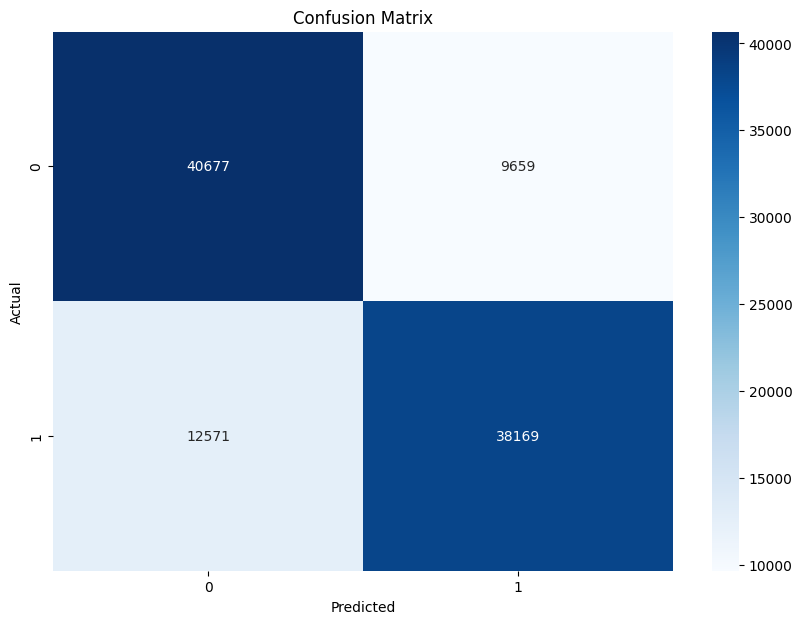

In [23]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

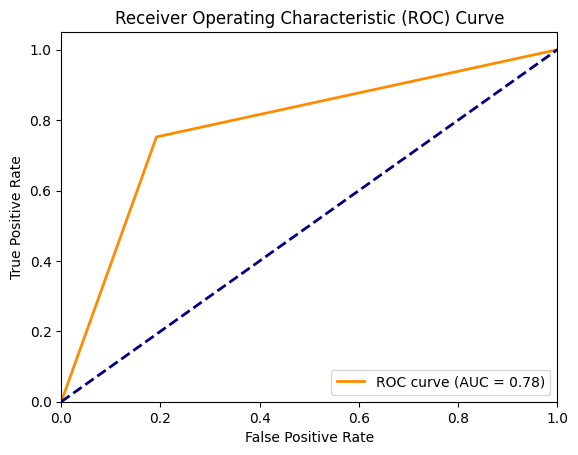

In [24]:
# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()